# Forecasting Cosmological Parameters

### Recreation of data from Table 3 of: https://arxiv.org/pdf/2106.09713, using FishLSS: https://github.com/NoahSailer/FishLSS in an attempt to inform the SIRMOS collaboration. Page created by MSc Student (Candidate Number: 277163) (University of Sussex), using code from Noah Sailer (University of California, Berkeley), and supervision from Dr Eva-Maria Mueller (University of Sussex)

### Setup 

In [106]:
# import revelant packages
import numpy as np
from classy import Class
from scipy.interpolate import interp1d,interp2d, make_interp_spline
from scipy.optimize import curve_fit
import scipy.integrate

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from FishLSS.fisherForecast import fisherForecast
from FishLSS.experiment import experiment

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [107]:
placeholder = [0,1,2,3,4,5] #[6]

non_redshift_dep = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio'])#,\
                            #'m_ncdm', 'N_eff', 'Omega_k', 'f_NL'])

redshift_dep_pkmu = np.array(['b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

redshift_dep_cl = np.array(['N','alpha0','alphax','b','b2','bs'])

basis_pkmu_placeholder = np.concatenate([non_redshift_dep, redshift_dep_pkmu])

basis_cl_placeholder = np.concatenate([non_redshift_dep, redshift_dep_cl])

globe = len(non_redshift_dep)

params = {"output": "lCl mPk",
    "P_k_max_h/Mpc": 2.0,
    "non linear": "halofit",
    "z_pk": "0.0,1087",
    "A_s": 2.10732e-09,
    "n_s": 0.96824,
    "h": 0.677,
    "N_eff": 3.046,
    "N_ncdm": 3,
    "m_ncdm": "0.0,0.01,0.05",
    "tau_reio": 0.0568,
    "omega_b": 0.02247,
    "omega_cdm": 0.11923,
    'Omega_k': 0, 
  }

cosmo = Class() 
cosmo.set(params) 
cosmo.compute() 


## CMB priors

$\Lambda\text{CDM}$ + $M_\nu$ + $N_\text{eff}$ + $\Omega_k$

$\{h,\,\ln(A_s),\,n_s,\,\omega_c,\,\omega_b,\,\tau,\,M_\nu,\,N_\text{eff},\,\alpha_s,\,\Omega_k,\,f_\text{NL}^\text{Loc}\}$ - before


In [108]:
F_Planck = np.genfromtxt('input/Planck.txt')
F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_S4 = np.genfromtxt('input/Planck_S4.txt')
F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_SO = np.genfromtxt('input/LiteBIRD_SO.txt')

if 'm_ncdm' in non_redshift_dep:
    indices = [0, 1, 2, 3, 4, 5, 6]
elif 'N_eff' in non_redshift_dep:
    indices = [0, 1, 2, 3, 4, 5, 7]
elif 'Omega_k' in non_redshift_dep:
    indices = [0, 1, 2, 3, 4, 5, 9]
elif 'f_NL' in non_redshift_dep:
    indices = [0, 1, 2, 3, 4, 5, 10]
else:
    indices = [0, 1, 2, 3, 4, 5]


F_Planck_new = F_Planck.reshape(11,11)
F_Planck_new = np.asmatrix(F_Planck_new[np.ix_(indices, indices)])

F_Planck_SO_new = F_Planck_SO.reshape(11,11)
F_Planck_SO_new = np.asmatrix(F_Planck_SO_new[np.ix_(indices, indices)])

F_Planck_S4_new = F_Planck_S4.reshape(11,11)
F_Planck_S4_new = np.asmatrix(F_Planck_S4_new[np.ix_(indices, indices)])

F_LiteBIRD_SO_new = F_LiteBIRD_SO.reshape(11,11)
F_LiteBIRD_SO_new = np.asmatrix(F_LiteBIRD_SO_new[np.ix_(indices, indices)])

F_LiteBIRD_S4_new = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new = np.asmatrix(F_LiteBIRD_S4_new[np.ix_(indices, indices)])


## DESI

## LSS Alone

In [109]:
bd_desi = 'data_test_msc/desi'
DESI = experiment(zmin = 0.6, zmax = 1.7, nbins = 4, ELG = True, fsky = 0.34)
desiCast = fisherForecast(experiment = DESI, Nk=2000,Nmu=100, cosmo = cosmo, velocileptors=True,name='DESI_fiducial', basedir=bd_desi)


In [110]:
desiCast.free_params = basis_pkmu_placeholder

desiCast.compute_derivatives()

basis_Pkmu_desi =  basis_pkmu_placeholder

derivatives_Pkmu_desi = desiCast.load_derivatives(basis_Pkmu_desi)

F_Pkmu_desi = desiCast.gen_fisher(basis_Pkmu_desi,globe,kmax_knl=1,derivatives=derivatives_Pkmu_desi) # change back to globe

F_Pkmu_desi[4,4] = F_Pkmu_desi[4,4] + (1/(0.0005)**2)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , ((np.sqrt(np.diag(np.linalg.inv(F_Pkmu_desi))))[i]*10**3))

    
F_Pkmu_desi[4,4] = F_Pkmu_desi[4,4] - (1/(0.0005)**2)


h: 56.4521765821401
log(A_s): 110.92289147399039
n_s: 22.863101439886684
omega_cdm: 35.95127342855875
omega_b: 0.4974183690370918
tau_reio: 61703.11001303389


## Planck + DESI

In [111]:
F_planck_desi = desiCast.combine_fishers([F_Planck_new, F_Pkmu_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_desi))))[i]*10**3)


h: 30.816598145329092
log(A_s): 11.573632215008738
n_s: 2.6041004656147964
omega_cdm: 7.086740613163359
omega_b: 0.10577654367940416
tau_reio: 5.642072367778314


## Planck + SO + DESI (PSD)

In [112]:
F_planck_SO_desi = desiCast.combine_fishers([F_Planck_SO_new, F_Pkmu_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_desi))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_desi_m_ncdm = F_planck_SO_desi
    np.savetxt('F_Pkmu_desi_m_ncdm.txt', F_Pkmu_desi_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_desi_n_eff = F_planck_SO_desi
    np.savetxt('F_Pkmu_desi_n_eff.txt', F_Pkmu_desi_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_desi_omega_k = F_planck_SO_desi
    np.savetxt('F_Pkmu_desi_omega_k.txt', F_Pkmu_desi_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_desi_f_nl = F_planck_SO_desi
    np.savetxt('F_Pkmu_desi_f_nl.txt', F_Pkmu_desi_f_nl)
    
else:
    F_Pkmu_desi_no_ext = F_planck_SO_desi
    np.savetxt('F_Pkmu_desi_no_ext.txt', F_Pkmu_desi_no_ext)

h: 22.991205920446976
log(A_s): 11.550435667965228
n_s: 2.1199375283752606
omega_cdm: 6.028829664844837
omega_b: 0.04214656090522462
tau_reio: 5.605942248060861


## Planck + S4 + DESI

In [113]:
F_planck_S4_desi = desiCast.combine_fishers([F_Planck_S4_new, F_Pkmu_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_desi))))[i]*10**3)


h: 21.09729525092516
log(A_s): 11.541748129857003
n_s: 1.8369011805814157
omega_cdm: 5.668586405533593
omega_b: 0.024438477777838516
tau_reio: 5.58728704174716


## LiteBIRD + SO + DESI

In [114]:
F_litebird_SO_desi = desiCast.combine_fishers([F_LiteBIRD_SO_new, F_Pkmu_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_desi))))[i]*10**3)


h: 22.965009814672317
log(A_s): 4.445849738456089
n_s: 2.093234864208231
omega_cdm: 6.017628882527663
omega_b: 0.041934042435123546
tau_reio: 2.011142222383835


## LiteBIRD + S4 + DESI

In [115]:
F_litebird_S4_desi = desiCast.combine_fishers([F_LiteBIRD_S4_new, F_Pkmu_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_desi))))[i]*10**4)
    else:
        print(basis_Pkmu_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_desi))))[i]*10**3)


h: 21.068864556175317
log(A_s): 4.408216905720227
n_s: 1.8196339256953151
omega_cdm: 5.6587415833597605
omega_b: 0.024336981282000878
tau_reio: 2.0066687211749388


## DESI - Lensing Only

In [116]:
basis_Cl_desi = basis_cl_placeholder

desiCast.free_params = basis_Cl_desi

desiCast.compute_Cl_derivatives()

F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_desi))))[i]*10**3)


h: 3390.491468931691
log(A_s): 1152.2889171909467
n_s: 361.973479058032
omega_cdm: 1393.8378794609423
omega_b: 41.50671953512744
tau_reio: 4506.6542439236455


## DESI - LSS + Lensing

In [117]:
F_Pkmu_Cl_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_desi))))[i]*10**3)
    


h: 289.1687229382697
log(A_s): 82.54063003690503
n_s: 35.905697640513985
omega_cdm: 115.6277660759408
omega_b: 3.7027413033044048
tau_reio: 2600.2728554907844


## DESI - LSS + Planck + Lensing

In [118]:
F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')


F_Pkmu_Cl_Planck_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_desi))))[i]*10**3)


h: 29.23244852599282
log(A_s): 11.003135212128612
n_s: 2.5607561683193905
omega_cdm: 6.7083665793377145
omega_b: 0.10480680297631989
tau_reio: 5.444197262804215


## DESI - LSS + Planck + SO + Lensing

In [119]:
F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')


F_Pkmu_Cl_Planck_SO_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_desi))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_Cl_desi_m_ncdm = F_Pkmu_Cl_Planck_SO_desi
    np.savetxt('F_Pkmu_Cl_desi_m_ncdm.txt', F_Pkmu_Cl_desi_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_Cl_desi_n_eff = F_Pkmu_Cl_Planck_SO_desi
    np.savetxt('F_Pkmu_Cl_desi_n_eff.txt', F_Pkmu_Cl_desi_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_Cl_desi_omega_k = F_Pkmu_Cl_Planck_SO_desi
    np.savetxt('F_Pkmu_Cl_desi_omega_k.txt', F_Pkmu_Cl_desi_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_Cl_desi_f_nl = F_Pkmu_Cl_Planck_SO_desi
    np.savetxt('F_Pkmu_Cl_desi_f_nl.txt', F_Pkmu_Cl_desi_f_nl)
    
else:
    F_Pkmu_Cl_desi_no_ext = F_Pkmu_Cl_Planck_SO_desi
    np.savetxt('F_Pkmu_Cl_desi_no_ext.txt', F_Pkmu_Cl_desi_no_ext)

h: 19.318941968298507
log(A_s): 8.032050793613736
n_s: 2.032726134135749
omega_cdm: 5.062513825923535
omega_b: 0.04176499169064501
tau_reio: 4.328258180049912


## DESI - LSS + Planck + S4 + Lensing

In [120]:
F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_Planck_S4_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_desi))))[i]*10**3)


h: 17.377119777689792
log(A_s): 7.108568537842944
n_s: 1.7380730227372343
omega_cdm: 4.673636781511061
omega_b: 0.024289287243091942
tau_reio: 3.9484700656553127


## DESI - LSS + LiteBIRD + SO + Lensing

In [121]:
F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_litebird_SO_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_desi))))[i]*10**3)


h: 16.537228770529296
log(A_s): 3.8511651319923272
n_s: 1.8736011080280857
omega_cdm: 4.265523669915119
omega_b: 0.04164433725477644
tau_reio: 1.961993295447636


## DESI - LSS + LiteBIRD + S4 + Lensing

In [122]:
F_Cl_desi = desiCast.gen_lensing_fisher(basis_Cl_desi,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_litebird_S4_desi = desiCast.combine_fishers([F_Pkmu_desi,F_Cl_desi, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_desi))))[i]*10**4)
    else:
        print(basis_Cl_desi[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_desi))))[i]*10**3)


h: 13.000373972510408
log(A_s): 3.628669016067858
n_s: 1.5442790135142235
omega_cdm: 3.4560053638043415
omega_b: 0.024204778832016206
tau_reio: 1.9292183265841496


# Euclid

## LSS Alone

In [123]:
bd_euclid = 'data_test_msc/euclid'
Euclid = experiment(zmin = 0.9, zmax = 1.8, nbins = 4, Euclid = True, fsky = 0.36)
euclidCast = fisherForecast(experiment = Euclid, Nk=2000,Nmu=100, cosmo = cosmo, velocileptors=True,name='Euclid_fiducial', basedir=bd_euclid)


In [124]:
basis_Pkmu_euclid = basis_pkmu_placeholder

euclidCast.free_params = basis_Pkmu_euclid

euclidCast.compute_derivatives()

derivatives_Pkmu_euclid = euclidCast.load_derivatives(basis_Pkmu_euclid)

F_Pkmu_euclid = euclidCast.gen_fisher(basis_Pkmu_euclid,globe,kmax_knl=1,derivatives=derivatives_Pkmu_euclid)

F_Pkmu_euclid[4,4] = F_Pkmu_euclid[4,4] + (1/(0.0005)**2)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_euclid))))[i]*10**3)
    
    
F_Pkmu_euclid[4,4] = F_Pkmu_euclid[4,4] - (1/(0.0005)**2)


h: 53.7245796115959
log(A_s): 95.37384636928176
n_s: 19.377757434987775
omega_cdm: 30.270054842816897
omega_b: 0.4958499646969698
tau_reio: 53772.421383136585


## Planck + Euclid

In [125]:
F_planck_euclid = euclidCast.combine_fishers([F_Pkmu_euclid, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_euclid))))[i]*10**3)


h: 30.415460511510403
log(A_s): 11.434256234310192
n_s: 2.6252351954503714
omega_cdm: 7.04206460986129
omega_b: 0.10430432823933769
tau_reio: 5.50689427629835


## Planck + SO + Euclid

In [126]:
F_planck_SO_euclid = euclidCast.combine_fishers([F_Pkmu_euclid, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_euclid))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_euclid_m_ncdm = F_planck_SO_euclid
    np.savetxt('F_Pkmu_euclid_m_ncdm.txt', F_Pkmu_euclid_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_euclid_n_eff = F_planck_SO_euclid
    np.savetxt('F_Pkmu_euclid_n_eff.txt', F_Pkmu_euclid_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_euclid_omega_k = F_planck_SO_euclid
    np.savetxt('F_Pkmu_euclid_omega_k.txt', F_Pkmu_euclid_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_euclid_f_nl = F_planck_SO_euclid
    np.savetxt('F_Pkmu_euclid_f_nl.txt', F_Pkmu_euclid_f_nl)
    
else:
    F_Pkmu_euclid_no_ext = F_planck_SO_euclid
    np.savetxt('F_Pkmu_euclid_no_ext.txt', F_Pkmu_euclid_no_ext)

h: 22.824999832679474
log(A_s): 11.375678328316315
n_s: 2.1305942148020285
omega_cdm: 6.003652883333676
omega_b: 0.041759541974376674
tau_reio: 5.472186560201813


## Planck + S4 + Euclid

In [127]:
F_planck_S4_euclid = euclidCast.combine_fishers([F_Pkmu_euclid, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_euclid))))[i]*10**3)


h: 20.99861267397555
log(A_s): 11.345150491245438
n_s: 1.8470621944388097
omega_cdm: 5.6500022053768735
omega_b: 0.024330167572789045
tau_reio: 5.446385430246961


## LiteBIRD + SO + Euclid

In [128]:
F_litebird_SO_euclid = euclidCast.combine_fishers([F_Pkmu_euclid, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_euclid))))[i]*10**3)


h: 22.78411051025355
log(A_s): 4.465731141658195
n_s: 2.108305048844693
omega_cdm: 5.994768879680948
omega_b: 0.04142996959214681
tau_reio: 2.001237056929314


## LiteBIRD + S4 + Euclid

In [129]:
F_litebird_S4_euclid = euclidCast.combine_fishers([F_Pkmu_euclid, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_euclid))))[i]*10**4)
    else:
        print(basis_Pkmu_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_euclid))))[i]*10**3)


h: 20.969111984739662
log(A_s): 4.424297334561652
n_s: 1.8341481772077992
omega_cdm: 5.64266118869097
omega_b: 0.024190877600300708
tau_reio: 1.9966428917321302


## Euclid - Lensing Only

In [130]:
basis_Cl_euclid = basis_cl_placeholder

euclidCast.free_params = basis_Cl_euclid

euclidCast.compute_Cl_derivatives()


In [131]:
F_Cl_euclid = euclidCast.gen_lensing_fisher(basis_Cl_euclid,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_euclid))))[i]*10**3)


h: 2562.4840255882054
log(A_s): 921.5810147510507
n_s: 297.8892724981125
omega_cdm: 1092.876525462984
omega_b: 31.991737487425286
tau_reio: 3844.164871478387


## Euclid - LSS + Lensing

In [132]:
F_Pkmu_Cl_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_euclid))))[i]*10**3)
    
    

h: 231.92004980768922
log(A_s): 61.94144129872594
n_s: 27.52744099484693
omega_cdm: 91.30332360122054
omega_b: 3.0097145421634868
tau_reio: 2591.0508538646222


## Euclid - LSS + Planck + Lensing

In [133]:
F_Pkmu_Cl_Planck_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_euclid))))[i]*10**3)


h: 28.42975224056551
log(A_s): 10.791254337628555
n_s: 2.5715280074380296
omega_cdm: 6.5710080232235235
omega_b: 0.10312839795432557
tau_reio: 5.287638938024162


## Euclid - LSS + Planck + SO + Lensing

In [134]:
F_Cl_euclid = euclidCast.gen_lensing_fisher(basis_Cl_euclid,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_Planck_SO_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_euclid))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_Cl_euclid_m_ncdm = F_Pkmu_Cl_Planck_SO_euclid
    np.savetxt('F_Pkmu_Cl_euclid_m_ncdm.txt', F_Pkmu_Cl_euclid_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_Cl_euclid_n_eff = F_Pkmu_Cl_Planck_SO_euclid
    np.savetxt('F_Pkmu_Cl_euclid_n_eff.txt', F_Pkmu_Cl_euclid_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_Cl_euclid_omega_k = F_Pkmu_Cl_Planck_SO_euclid
    np.savetxt('F_Pkmu_Cl_euclid_omega_k.txt', F_Pkmu_Cl_euclid_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_Cl_euclid_f_nl = F_Pkmu_Cl_Planck_SO_euclid
    np.savetxt('F_Pkmu_Cl_euclid_f_nl.txt', F_Pkmu_Cl_euclid_f_nl)
    
else:
    F_Pkmu_Cl_euclid_no_ext = F_Pkmu_Cl_Planck_SO_euclid
    np.savetxt('F_Pkmu_Cl_euclid_no_ext.txt', F_Pkmu_Cl_euclid_no_ext)


h: 18.449089748785397
log(A_s): 7.712110551639838
n_s: 2.029847446863854
omega_cdm: 4.855867305927102
omega_b: 0.04135558967308397
tau_reio: 4.1568273975332


## Euclid - LSS + Planck + S4 + Lensing

In [135]:
F_Cl_euclid = euclidCast.gen_lensing_fisher(basis_Cl_euclid,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_Planck_S4_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_euclid))))[i]*10**3)


h: 16.57861508227075
log(A_s): 6.796812479269642
n_s: 1.7328659545219303
omega_cdm: 4.46962803793991
omega_b: 0.02417932603762453
tau_reio: 3.784145711963067


## Euclid - LSS + LiteBIRD + SO + Lensing

In [136]:
F_Cl_euclid = euclidCast.gen_lensing_fisher(basis_Cl_euclid,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_litebird_SO_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_euclid))))[i]*10**3)


h: 16.22890046179125
log(A_s): 3.818188139561003
n_s: 1.8690814658982342
omega_cdm: 4.204960103381535
omega_b: 0.041173285147494826
tau_reio: 1.9451661864518566


## Euclid - LSS + LiteBIRD + S4 + Lensing

In [137]:
F_Cl_euclid = euclidCast.gen_lensing_fisher(basis_Cl_euclid,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_litebird_S4_euclid = euclidCast.combine_fishers([F_Pkmu_euclid,F_Cl_euclid, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_euclid))))[i]*10**4)
    else:
        print(basis_Cl_euclid[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_euclid))))[i]*10**3)


h: 12.787598453450329
log(A_s): 3.58379730391631
n_s: 1.5420447648831588
omega_cdm: 3.4072464682434895
omega_b: 0.024056661975157302
tau_reio: 1.9096584475991227


# MSE

## LSS Alone

In [138]:
bd_mse = 'data_test_msc/mse'
MSE = experiment(zmin = 1.6, zmax = 4, nbins = 4, MSE = True, fsky = 0.24)
mseCast = fisherForecast(experiment = MSE, Nk=2000,Nmu=100, cosmo = cosmo, velocileptors=True,name='MSE_fiducial', basedir=bd_mse)


In [139]:
basis_Pkmu_mse = basis_pkmu_placeholder

mseCast.free_params = basis_Pkmu_mse

mseCast.compute_derivatives()

derivatives_Pkmu_mse = mseCast.load_derivatives(basis_Pkmu_mse)

F_Pkmu_mse = mseCast.gen_fisher(basis_Pkmu_mse,globe,kmax_knl=1,derivatives=derivatives_Pkmu_mse)

F_Pkmu_mse[4,4] = F_Pkmu_mse[4,4] + (1/(0.0005)**2)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_mse))))[i]*10**3)
    
    
F_Pkmu_mse[4,4] = F_Pkmu_mse[4,4] - (1/(0.0005)**2)


h: 44.73102870375073
log(A_s): 56.04039428336955
n_s: 10.592732979026064
omega_cdm: 18.94144621565835
omega_b: 0.4708079402562934
tau_reio: 31546.869942835947


## Planck + MSE

In [140]:
F_planck_SO_mse = mseCast.combine_fishers([F_Pkmu_mse, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mse))))[i]*10**3)


h: 21.43649860643909
log(A_s): 11.707776037694174
n_s: 2.5634165884782285
omega_cdm: 5.264714793377557
omega_b: 0.09235234619827924
tau_reio: 5.489143718727636


## Planck + SO + MSE

In [141]:
F_planck_SO_mse = mseCast.combine_fishers([F_Pkmu_mse, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mse))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_mse_m_ncdm = F_planck_SO_mse
    np.savetxt('F_Pkmu_mse_m_ncdm.txt', F_Pkmu_mse_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_mse_n_eff = F_planck_SO_mse
    np.savetxt('F_Pkmu_mse_n_eff.txt', F_Pkmu_mse_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_mse_omega_k = F_planck_SO_mse
    np.savetxt('F_Pkmu_mse_omega_k.txt', F_Pkmu_mse_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_mse_f_nl = F_planck_SO_mse
    np.savetxt('F_Pkmu_mse_f_nl.txt', F_Pkmu_mse_f_nl)
    
else:
    F_Pkmu_mse_no_ext = F_planck_SO_mse
    np.savetxt('F_Pkmu_mse_no_ext.txt', F_Pkmu_mse_no_ext)

h: 17.6179742548788
log(A_s): 11.53089476235624
n_s: 2.105975262919904
omega_cdm: 4.761637518158245
omega_b: 0.039637567438096814
tau_reio: 5.403746268312535


## Planck + S4 + MSE

In [142]:
F_planck_S4_mse = mseCast.combine_fishers([F_Pkmu_mse, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_mse))))[i]*10**3)


h: 16.710179044840665
log(A_s): 11.424048546936431
n_s: 1.8119770157895845
omega_cdm: 4.554450469579914
omega_b: 0.02377893697576402
tau_reio: 5.341934628018189


## LiteBIRD + SO + MSE

In [143]:
F_litebird_SO_mse = mseCast.combine_fishers([F_Pkmu_mse, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_mse))))[i]*10**3)


h: 16.724748820135027
log(A_s): 4.512384743506735
n_s: 2.094695048622052
omega_cdm: 4.561663751326421
omega_b: 0.03906535682867557
tau_reio: 1.9833752501183977


## LiteBIRD + S4 + MSE

In [144]:
F_litebird_S4_mse = mseCast.combine_fishers([F_Pkmu_mse, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_mse))))[i]*10**4)
    else:
        print(basis_Pkmu_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_mse))))[i]*10**3)


h: 15.896727341532207
log(A_s): 4.46754680345705
n_s: 1.8050314085519208
omega_cdm: 4.353903801994446
omega_b: 0.02356434214499074
tau_reio: 1.9773299757269822


## MSE - Lensing Only

In [145]:
basis_Cl_mse = basis_cl_placeholder

mseCast.free_params = basis_Cl_mse

mseCast.compute_Cl_derivatives()


In [146]:
F_Cl_mse = mseCast.gen_lensing_fisher(basis_Cl_mse,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_mse))))[i]*10**3)



h: 2710.823017147197
log(A_s): 1132.6813863964867
n_s: 367.6190153877081
omega_cdm: 1290.5981463276667
omega_b: 35.05048347660987
tau_reio: 4063.8407684266913


## MSE - LSS + Lensing

In [147]:
F_Pkmu_Cl_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_mse))))[i]*10**3)
        

h: 88.5373846546549
log(A_s): 25.66952337125608
n_s: 12.03155985091123
omega_cdm: 36.95199271210372
omega_b: 1.1881624850122094
tau_reio: 2597.879806517603


## MSE - LSS + Planck + Lensing

In [148]:
F_Pkmu_Cl_Planck_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_mse))))[i]*10**3)


h: 20.385761997521783
log(A_s): 10.859570359549899
n_s: 2.5224251995710363
omega_cdm: 4.996522330655622
omega_b: 0.09216170093174562
tau_reio: 5.166760135282525


## MSE - LSS + Planck + SO + Lensing

In [149]:
F_Cl_mse = mseCast.gen_lensing_fisher(basis_Cl_mse,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_Planck_SO_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_mse))))[i]*10**3)

if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_Cl_mse_m_ncdm = F_Pkmu_Cl_Planck_SO_mse
    np.savetxt('F_Pkmu_Cl_mse_m_ncdm.txt', F_Pkmu_Cl_mse_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_Cl_mse_n_eff = F_Pkmu_Cl_Planck_SO_mse
    np.savetxt('F_Pkmu_Cl_mse_n_eff.txt', F_Pkmu_Cl_mse_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_Cl_mse_omega_k = F_Pkmu_Cl_Planck_SO_mse
    np.savetxt('F_Pkmu_Cl_mse_omega_k.txt', F_Pkmu_Cl_mse_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_Cl_mse_f_nl = F_Pkmu_Cl_Planck_SO_mse
    np.savetxt('F_Pkmu_Cl_mse_f_nl.txt', F_Pkmu_Cl_mse_f_nl)
    
else:
    F_Pkmu_Cl_mse_no_ext = F_Pkmu_Cl_Planck_SO_mse
    np.savetxt('F_Pkmu_Cl_mse_no_ext.txt', F_Pkmu_Cl_mse_no_ext)
    

h: 13.455630707977258
log(A_s): 6.805098521198301
n_s: 1.9942734775609283
omega_cdm: 3.669316044552804
omega_b: 0.039475911946004374
tau_reio: 3.612140291135341


## MSE - LSS + Planck + S4 + Lensing

In [150]:
F_Cl_mse = mseCast.gen_lensing_fisher(basis_Cl_mse,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_Planck_S4_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_mse))))[i]*10**3)


h: 12.16245723508799
log(A_s): 5.5983067285849994
n_s: 1.6920678155913318
omega_cdm: 3.343736953031427
omega_b: 0.02367745130421659
tau_reio: 3.11481407345221


## MSE - LSS + LiteBIRD + SO + Lensing

In [151]:
F_Cl_mse = mseCast.gen_lensing_fisher(basis_Cl_mse,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_litebird_SO_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_mse))))[i]*10**3)


h: 12.966003598784996
log(A_s): 3.7318484723509564
n_s: 1.850952071359801
omega_cdm: 3.4884041982667675
omega_b: 0.03869940047774065
tau_reio: 1.8736542317910478


## MSE - LSS + LiteBIRD + S4 + Lensing

In [152]:
F_Cl_mse = mseCast.gen_lensing_fisher(basis_Cl_mse,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_litebird_S4_mse = mseCast.combine_fishers([F_Pkmu_mse,F_Cl_mse, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_mse))))[i]*10**4)
    else:
        print(basis_Cl_mse[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_mse))))[i]*10**3)


h: 10.715296101760897
log(A_s): 3.384547206044855
n_s: 1.5308792748477609
omega_cdm: 2.9114843707410722
omega_b: 0.023250049487220543
tau_reio: 1.8024791282133144


# MegaMapper

## LSS Alone

In [153]:
bd_mm = 'data_test_msc/mm'

n_mm = interp1d([2,3,4,5],np.array([9.8,1.2,1.0,0.4])*(1e-4),kind='linear')
MegaMapper = experiment(zmin=2., zmax=5., nbins=4, fsky=0.34, n=n_mm, LBG=True, custom_n=True)
megaCast = fisherForecast(experiment=MegaMapper, Nk=2000,Nmu=100, cosmo=cosmo, velocileptors=True,name='MegaMapper_fiducial', basedir=bd_mm)

In [154]:
basis_Pkmu_mm = basis_pkmu_placeholder

megaCast.free_params = basis_Pkmu_mm

megaCast.compute_derivatives()

derivatives_Pkmu_mm = megaCast.load_derivatives(basis_Pkmu_mm)

F_Pkmu_mm = megaCast.gen_fisher(basis_Pkmu_mm,globe,kmax_knl=1,derivatives=derivatives_Pkmu_mm)

F_Pkmu_mm[4,4] = F_Pkmu_mm[4,4] + (1/(0.0005)**2)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_mm))))[i]*10**3)
    
    
F_Pkmu_mm[4,4] = F_Pkmu_mm[4,4] - (1/(0.0005)**2)


h: 41.943732564823584
log(A_s): 44.74555152467091
n_s: 9.02344064395623
omega_cdm: 17.906687466563326
omega_b: 0.4636821296888207
tau_reio: 25233.450443600483


## Planck + MegaMapper

In [155]:
F_planck_SO_mm = megaCast.combine_fishers([F_Pkmu_mm, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mm))))[i]*10**3)


h: 19.631312044459783
log(A_s): 11.405259726095371
n_s: 2.521090471590573
omega_cdm: 4.8948805022565365
omega_b: 0.0903660456758127
tau_reio: 5.358927695223269


## Planck + SO + MegaMapper

In [156]:
F_planck_SO_mm = megaCast.combine_fishers([F_Pkmu_mm, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_mm))))[i]*10**3)


if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_mm_m_ncdm = F_planck_SO_mm
    np.savetxt('F_Pkmu_mm_m_ncdm.txt', F_Pkmu_mm_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_mm_n_eff = F_planck_SO_mm
    np.savetxt('F_Pkmu_mm_n_eff.txt', F_Pkmu_mm_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_mm_omega_k = F_planck_SO_mm
    np.savetxt('F_Pkmu_mm_omega_k.txt', F_Pkmu_mm_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_mm_f_nl = F_planck_SO_mm
    np.savetxt('F_Pkmu_mm_f_nl.txt', F_Pkmu_mm_f_nl)
    
else:
    F_Pkmu_mm_no_ext = F_planck_SO_mm
    np.savetxt('F_Pkmu_mm_no_ext.txt', F_Pkmu_mm_no_ext)

h: 16.281773835642852
log(A_s): 11.259252929917503
n_s: 2.0812124387092776
omega_cdm: 4.440241892352018
omega_b: 0.03905331753210968
tau_reio: 5.281053981977325


## Planck + S4 + MegaMapper

In [157]:
F_planck_S4_mm = megaCast.combine_fishers([F_Pkmu_mm, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_mm))))[i]*10**3)


h: 15.507388503788123
log(A_s): 11.165791286482113
n_s: 1.7912503715301267
omega_cdm: 4.246355166786711
omega_b: 0.0235836965385382
tau_reio: 5.223565847479068


## LiteBIRD + SO + MegaMapper

In [158]:
F_litebird_SO_mm = megaCast.combine_fishers([F_Pkmu_mm, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_mm))))[i]*10**3)


h: 15.396473377342007
log(A_s): 4.486257523476132
n_s: 2.070146663570948
omega_cdm: 4.244299398470121
omega_b: 0.038523892624884475
tau_reio: 1.9769568340285968


## LiteBIRD + S4 + MegaMapper

In [159]:
F_litebird_S4_mm = megaCast.combine_fishers([F_Pkmu_mm, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_mm))))[i]*10**4)
    else:
        print(basis_Pkmu_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_mm))))[i]*10**3)


h: 14.67185026089853
log(A_s): 4.4438104646488705
n_s: 1.7845046635212243
omega_cdm: 4.041669344035589
omega_b: 0.02337629345515983
tau_reio: 1.9708199714960124


## MegaMapper - Lensing Only

In [160]:
basis_Cl_mm = basis_cl_placeholder

megaCast.free_params = basis_Cl_mm

megaCast.compute_Cl_derivatives()


In [161]:
F_Cl_mm = megaCast.gen_lensing_fisher(basis_Cl_mm,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_mm))))[i]*10**3)


h: 2563.034995067692
log(A_s): 1180.5299593503305
n_s: 395.7655907002061
omega_cdm: 1298.3216725551563
omega_b: 33.37213780957725
tau_reio: 3885.510169489306


## MegaMapper - LSS + Lensing

In [162]:
F_Pkmu_Cl_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_mm))))[i]*10**3)
    
    

h: 79.94752052266101
log(A_s): 22.637795894476106
n_s: 10.39562131352333
omega_cdm: 33.79049521398304
omega_b: 1.0828593740305326
tau_reio: 2553.0834388245325


## MegaMapper - LSS + Planck + Lensing

In [163]:
F_Pkmu_Cl_Planck_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_mm))))[i]*10**3)


h: 18.754303601082317
log(A_s): 10.638796914534334
n_s: 2.482856685385101
omega_cdm: 4.668348939713198
omega_b: 0.09025185900668815
tau_reio: 5.0667693024272


## MegaMapper - LSS + Planck + SO + Lensing

In [164]:
F_Cl_mm = megaCast.gen_lensing_fisher(basis_Cl_mm,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_Planck_SO_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_mm))))[i]*10**3)

        
if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_Cl_mm_m_ncdm = F_Pkmu_Cl_Planck_SO_mm
    np.savetxt('F_Pkmu_Cl_mm_m_ncdm.txt', F_Pkmu_Cl_mm_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_Cl_mm_n_eff = F_Pkmu_Cl_Planck_SO_mm
    np.savetxt('F_Pkmu_Cl_mm_n_eff.txt', F_Pkmu_Cl_mm_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_Cl_mm_omega_k = F_Pkmu_Cl_Planck_SO_mm
    np.savetxt('F_Pkmu_Cl_mm_omega_k.txt', F_Pkmu_Cl_mm_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_Cl_mm_f_nl = F_Pkmu_Cl_Planck_SO_mm
    np.savetxt('F_Pkmu_Cl_mm_f_nl.txt', F_Pkmu_Cl_mm_f_nl)
    
else:
    F_Pkmu_Cl_mm_no_ext = F_Pkmu_Cl_Planck_SO_mm
    np.savetxt('F_Pkmu_Cl_mm_no_ext.txt', F_Pkmu_Cl_mm_no_ext)

h: 12.468901230890397
log(A_s): 6.943159732180405
n_s: 1.9655985698276666
omega_cdm: 3.434402006238112
omega_b: 0.03894012561768779
tau_reio: 3.651211585944751


## MegaMapper - LSS + Planck + S4 + Lensing

In [165]:
F_Cl_mm = megaCast.gen_lensing_fisher(basis_Cl_mm,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_Planck_S4_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_mm))))[i]*10**3)


h: 11.151136111578074
log(A_s): 5.754247043284609
n_s: 1.6684741627339394
omega_cdm: 3.084356258007305
omega_b: 0.02350236886499759
tau_reio: 3.1617731233047643


## MegaMapper - LSS + LiteBIRD + SO + Lensing

In [166]:
F_Cl_mm = megaCast.gen_lensing_fisher(basis_Cl_mm,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_litebird_SO_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_SO_mm))))[i]*10**3)


h: 12.183248619575268
log(A_s): 3.7661935050958064
n_s: 1.828224408027308
omega_cdm: 3.3151658112865703
omega_b: 0.03802925549425314
tau_reio: 1.8754379612692906


## MegaMapper - LSS + LiteBIRD + S4 + Lensing

In [167]:
F_Cl_mm = megaCast.gen_lensing_fisher(basis_Cl_mm,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_litebird_S4_mm = megaCast.combine_fishers([F_Pkmu_mm,F_Cl_mm, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_S4_mm))))[i]*10**3)


h: 10.116095546685738
log(A_s): 3.433487377453083
n_s: 1.5113858470744177
omega_cdm: 2.7646658104605843
omega_b: 0.022965076662980383
tau_reio: 1.807405881836446


# SURVEY WITH HIGH AND LOW REDSHIFT ADDITIONS

## PSD + MegaMapper - No Lensing

In [168]:
F_Pkmu_PSD_mm = desiCast.combine_fishers([F_Pkmu_mm, F_planck_SO_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSD_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSD_mm))))[i]*10**3)


h: 14.266444184606739
log(A_s): 9.559571986119218
n_s: 1.9891092944176427
omega_cdm: 3.8991513197569505
omega_b: 0.03888609811942078
tau_reio: 4.594778445069109


## PSD + MegaMapper - Lensing

In [169]:
F_Pkmu_Cl_PSD_mm = desiCast.combine_fishers([F_Pkmu_mm, F_Pkmu_Cl_Planck_SO_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSD_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSD_mm))))[i]*10**3)


h: 11.732247822743927
log(A_s): 6.315230826355446
n_s: 1.9298900158092802
omega_cdm: 3.2406591591837675
omega_b: 0.038766268350469944
tau_reio: 3.3618702917232253


## LSD + MegaMapper - No Lensing

In [170]:
F_Pkmu_LSD_mm = desiCast.combine_fishers([F_Pkmu_mm, F_litebird_S4_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSD_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSD_mm))))[i]*10**3)


h: 13.337963858662853
log(A_s): 4.257221288363306
n_s: 1.7016262975719538
omega_cdm: 3.674536737696912
omega_b: 0.023179813942045865
tau_reio: 1.9334912013260093


## LSD + MegaMapper - Lensing

In [171]:
F_Pkmu_Cl_LSD_mm = desiCast.combine_fishers([F_Pkmu_mm, F_Pkmu_Cl_litebird_S4_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSD_mm))))[i]*10**4)
    else:
        print(basis_Cl_mm[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSD_mm))))[i]*10**3)


h: 9.724343953794653
log(A_s): 3.2832497040929214
n_s: 1.500470083015375
omega_cdm: 2.663103528091661
omega_b: 0.022898872591981877
tau_reio: 1.752049595811623


# SIRMOS Attempt - Data Set 2

In [172]:
bd_sirmos_2 = 'data_test_msc/sirmos_2'

zs_ha = np.linspace(1.05, 2.75, 18)
zs_o2 = np.linspace(2.85, 3.95, 12)
z_tot = np.concatenate((zs_ha, zs_o2))

z_tot_test = np.linspace(1,4,30)

galaxy_num_per_sq_deg_per_dz_sirmos_ha_2 = np.array([12471.3376, 9098.7261, 9200.6369, 12292.9936,
    8949.0446, 9894.9045, 8585.9873, 7691.0828,
    5831.2102, 5512.7389, 5152.8662, 4834.3949,
    3388.5350, 3191.0828, 2541.4013, 2038.2166,
    2366.2420, 2047.7707])

galaxy_num_per_sq_deg_per_dz_sirmos_o2_2 = np.array([1576.4331, 1493.6306, 939.4904, 1003.1847,
                                                    710.1911, 585.9873, 480.8917, 261.1465,
                                                    283.4395, 280.2548, 152.8662, 178.3439])

volume_ha_2 = np.array([((1.+z+0.05)*cosmo.angular_distance(z+0.05))**3. for z in zs_ha])
volume_ha_2 -= np.array([((1.+z-0.05)*cosmo.angular_distance(z-0.05))**3. for z in zs_ha])
volume_ha_2 *= 4.*np.pi*cosmo.pars['h']**3./3.

volume_o2_2 = np.array([((1.+z+0.05)*cosmo.angular_distance(z+0.05))**3. for z in zs_o2])
volume_o2_2 -= np.array([((1.+z-0.05)*cosmo.angular_distance(z-0.05))**3. for z in zs_o2])
volume_o2_2 *= 4.*np.pi*cosmo.pars['h']**3./3.

num_den_ha_2 = (41252.96125 / volume_ha_2) * galaxy_num_per_sq_deg_per_dz_sirmos_ha_2 * 0.1
num_den_o2_2 = (41252.96125 / volume_o2_2) * galaxy_num_per_sq_deg_per_dz_sirmos_o2_2 * 0.1

n_tot_sirmos_2 = np.concatenate((num_den_ha_2, num_den_o2_2))

n_sirmos_2 = interp1d(z_tot_test, n_tot_sirmos_2)

SIRMOS_2 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
sirmosCast_2 = fisherForecast(experiment = SIRMOS_2, Nk=2000,Nmu=100, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir=bd_sirmos_2)


## SIRMOS - LSS Alone

In [173]:
basis_Pkmu_sirmos_2 = basis_pkmu_placeholder

sirmosCast_2.free_params = basis_Pkmu_sirmos_2

sirmosCast_2.compute_derivatives()
derivatives_Pkmu_sirmos_2 = sirmosCast_2.load_derivatives(basis_Pkmu_sirmos_2)

F_Pkmu_sirmos_2 = sirmosCast_2.gen_fisher(basis_Pkmu_sirmos_2,globe,kmax_knl=1,derivatives=derivatives_Pkmu_sirmos_2)

F_Pkmu_sirmos_2[4,4] = F_Pkmu_sirmos_2[4,4] + (1/(0.0005)**2)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_2))))[i]*10**3)
    
F_Pkmu_sirmos_2[4,4] = F_Pkmu_sirmos_2[4,4] - (1/(0.0005)**2)


h: 37.608184133355635
log(A_s): 40.836406765626144
n_s: 8.034593497160845
omega_cdm: 16.42695075954577
omega_b: 0.46011650598137704
tau_reio: 23274.202096292935


## SIRMOS - LSS + Planck

In [174]:
F_planck_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_sirmos_2))))[i]*10**3)


h: 15.95935592111189
log(A_s): 7.575572220183579
n_s: 2.2582814557586226
omega_cdm: 3.9803560457726523
omega_b: 0.0911291790991298
tau_reio: 3.8030864844805117


## SIRMOS - LSS + Planck + SO

In [175]:
F_planck_SO_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_SO_sirmos_2))))[i]*10**3)


if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_sirmos_2_m_ncdm = F_planck_SO_sirmos_2
    np.savetxt('F_Pkmu_sirmos_2_m_ncdm.txt', F_Pkmu_sirmos_2_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_sirmos_2_n_eff = F_planck_SO_sirmos_2
    np.savetxt('F_Pkmu_sirmos_2_n_eff.txt', F_Pkmu_sirmos_2_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_sirmos_2_omega_k = F_planck_SO_sirmos_2
    np.savetxt('F_Pkmu_sirmos_2_omega_k.txt', F_Pkmu_sirmos_2_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_sirmos_2_f_nl = F_planck_SO_sirmos_2
    np.savetxt('F_Pkmu_sirmos_2_f_nl.txt', F_Pkmu_sirmos_2_f_nl)
    
else:
    F_Pkmu_sirmos_2_no_ext = F_planck_SO_sirmos_2
    np.savetxt('F_Pkmu_sirmos_2_no_ext.txt', F_Pkmu_sirmos_2_no_ext)
    

h: 13.380067706612033
log(A_s): 7.432239817801312
n_s: 1.897869781631721
omega_cdm: 3.609056983666937
omega_b: 0.03928632485464278
tau_reio: 3.6933112661086507


## SIRMOS - LSS + Planck + S4

In [176]:
F_planck_S4_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_planck_S4_sirmos_2))))[i]*10**3)


h: 12.878098099073634
log(A_s): 7.333572839954115
n_s: 1.6385855232176372
omega_cdm: 3.5072736766957617
omega_b: 0.02357731778836129
tau_reio: 3.600427256850482


## SIRMOS - LSS + LiteBIRD + SO

In [177]:
F_litebird_SO_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_SO_sirmos_2))))[i]*10**3)

h: 13.178790682069831
log(A_s): 3.9561969186675037
n_s: 1.827565026319436
omega_cdm: 3.582963065035518
omega_b: 0.0380722163017822
tau_reio: 1.8628817892282885


## SIRMOS - LSS + LiteBIRD + S4

In [178]:
F_litebird_S4_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_litebird_S4_sirmos_2))))[i]*10**3)

h: 12.697954393297527
log(A_s): 3.9405204401863045
n_s: 1.5996752773132772
omega_cdm: 3.473329682695554
omega_b: 0.023022347449451662
tau_reio: 1.84623508466698


## SIRMOS - Lensing Only

In [179]:
basis_Cl_sirmos_2 = basis_cl_placeholder

sirmosCast_2.free_params = basis_Cl_sirmos_2

sirmosCast_2.compute_Cl_derivatives()


In [180]:
F_Cl_sirmos_2 = sirmosCast_2.gen_lensing_fisher(basis_Cl_sirmos_2,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='Planck')

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Cl_sirmos_2))))[i]*10**3)


h: 2167.7814754860337
log(A_s): 855.9193856369315
n_s: 279.41713982584963
omega_cdm: 987.990620968139
omega_b: 27.641190220317377
tau_reio: 3478.187330766964


## SIRMOS - LSS + Lensing

In [181]:
F_Pkmu_Cl_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i] + ':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_sirmos_2))))[i]*10**3)

    

h: 81.6104580205019
log(A_s): 20.03739339067049
n_s: 9.591447269878788
omega_cdm: 33.4971280452301
omega_b: 1.0973598865487757
tau_reio: 2445.048615445732


## SIRMOS - LSS + Planck + Lensing

In [182]:
F_Pkmu_Cl_Planck_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2, F_Planck_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_sirmos_2))))[i]*10**3)


h: 15.615763292946601
log(A_s): 7.3587709137186215
n_s: 2.251399839836233
omega_cdm: 3.894357075952469
omega_b: 0.09099627863178182
tau_reio: 3.726028493440337


## SIRMOS - LSS + Planck + SO + Lensing

In [183]:
F_Cl_sirmos_2 = sirmosCast_2.gen_lensing_fisher(basis_Cl_sirmos_2,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_Planck_SO_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2, F_Planck_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_SO_sirmos_2))))[i]*10**3)


if 'm_ncdm' in non_redshift_dep:
    F_Pkmu_Cl_sirmos_2_m_ncdm = F_Pkmu_Cl_Planck_SO_sirmos_2
    np.savetxt('F_Pkmu_Cl_sirmos_2_m_ncdm.txt', F_Pkmu_Cl_sirmos_2_m_ncdm)
    
elif 'N_eff' in non_redshift_dep:
    F_Pkmu_Cl_sirmos_2_n_eff = F_Pkmu_Cl_Planck_SO_sirmos_2
    np.savetxt('F_Pkmu_Cl_sirmos_2_n_eff.txt', F_Pkmu_Cl_sirmos_2_n_eff)
    
if 'Omega_k' in non_redshift_dep:
    F_Pkmu_Cl_sirmos_2_omega_k = F_Pkmu_Cl_Planck_SO_sirmos_2
    np.savetxt('F_Pkmu_Cl_sirmos_2_omega_k.txt', F_Pkmu_Cl_sirmos_2_omega_k)
    
elif 'f_NL' in non_redshift_dep:
    F_Pkmu_Cl_sirmos_2_f_nl = F_Pkmu_Cl_Planck_SO_sirmos_2
    np.savetxt('F_Pkmu_Cl_sirmos_2_f_nl.txt', F_Pkmu_Cl_sirmos_2_f_nl)
    
else:
    F_Pkmu_Cl_sirmos_2_no_ext = F_Pkmu_Cl_Planck_SO_sirmos_2
    np.savetxt('F_Pkmu_Cl_sirmos_2_no_ext.txt', F_Pkmu_Cl_sirmos_2_no_ext)
    

h: 11.23059835181407
log(A_s): 5.530916719896855
n_s: 1.871788043747292
omega_cdm: 3.0684541805293666
omega_b: 0.038990099592361084
tau_reio: 2.996454319717554


## SIRMOS - LSS + Planck + S4 + Lensing

In [184]:
F_Cl_sirmos_2 = sirmosCast_2.gen_lensing_fisher(basis_Cl_sirmos_2,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_Planck_S4_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2, F_Planck_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_Planck_S4_sirmos_2))))[i]*10**3)


h: 10.07546576211628
log(A_s): 4.637414006906378
n_s: 1.6034892688326283
omega_cdm: 2.781872573799176
omega_b: 0.023397363915695312
tau_reio: 2.608564349616712


## SIRMOS - LSS + SO + LiteBIRD + Lensing

In [185]:
F_Cl_sirmos_2 = sirmosCast_2.gen_lensing_fisher(basis_Cl_sirmos_2,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='SO')

F_Pkmu_Cl_litebird_so_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2, F_LiteBIRD_SO_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_so_sirmos_2))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_so_sirmos_2))))[i]*10**3)
        

h: 11.088990830852998
log(A_s): 3.435899316999517
n_s: 1.7220618496127502
omega_cdm: 2.990001758269858
omega_b: 0.037907366853363225
tau_reio: 1.77178709561523


## SIRMOS - LSS + Lensing + LiteBIRD + S4

In [186]:
F_Cl_sirmos_2 = sirmosCast_2.gen_lensing_fisher(basis_Cl_sirmos_2,globe,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

F_Pkmu_Cl_litebird_s4_sirmos_2 = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2,F_Cl_sirmos_2, F_LiteBIRD_S4_new],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_s4_sirmos_2))))[i]*10**4)
    else:
        print(basis_Pkmu_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_litebird_s4_sirmos_2))))[i]*10**3)
        

h: 9.452722755109514
log(A_s): 3.1240461775449804
n_s: 1.4667191407163662
omega_cdm: 2.5777333395915165
omega_b: 0.022884015983431316
tau_reio: 1.6874949884657164


# SIRMOS WITH LOW REDSHIFT DATA

## SIRMOS + Planck + SO + DESI - No Lensing

In [187]:
F_Pkmu_PSD_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_planck_SO_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSD_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSD_sirmos))))[i]*10**3)


h: 12.354030690210626
log(A_s): 6.933403714250238
n_s: 1.8642059075719968
omega_cdm: 3.340379744713334
omega_b: 0.03913483906980427
tau_reio: 3.4990072151154537


## SIRMOS + Planck + SO + DESI - Lensing

In [188]:
F_Pkmu_Cl_PSD_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Pkmu_Cl_Planck_SO_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSD_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSD_sirmos))))[i]*10**3)


h: 10.666057756248497
log(A_s): 5.348081343867909
n_s: 1.847549861210644
omega_cdm: 2.920386252124029
omega_b: 0.0388670087078834
tau_reio: 2.9122937382683873


## SIRMOS + LiteBIRD + S4 + DESI - No Lensing

In [189]:
F_Pkmu_LSD_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_litebird_S4_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSD_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSD_sirmos))))[i]*10**3)


h: 11.819986862316993
log(A_s): 3.826881543920202
n_s: 1.55729164397093
omega_cdm: 3.234698040993894
omega_b: 0.022915661678252618
tau_reio: 1.8214885492023536


## SIRMOS + LiteBIRD + S4 + DESI - Lensing

In [190]:
F_Pkmu_Cl_LSD_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Pkmu_Cl_litebird_S4_desi],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSD_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSD_sirmos))))[i]*10**3)


h: 9.093431284540914
log(A_s): 3.0793312971744395
n_s: 1.4524510797825916
omega_cdm: 2.483094430908302
omega_b: 0.02281153049492603
tau_reio: 1.6676672793085114


## SIRMOS + Planck + SO + Euclid - No Lensing

In [191]:
F_Pkmu_PSE_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_planck_SO_euclid],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSE_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_PSE_sirmos))))[i]*10**3)


h: 12.407231134687272
log(A_s): 6.938355739052799
n_s: 1.8624191576100575
omega_cdm: 3.3571645167601942
omega_b: 0.039027084866638674
tau_reio: 3.4938958762762864


## SIRMOS + Planck + SO + Euclid - Lensing

In [192]:
F_Pkmu_Cl_PSE_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Pkmu_Cl_Planck_SO_euclid],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSE_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_PSE_sirmos))))[i]*10**3)


h: 10.62121923790936
log(A_s): 5.325182579761288
n_s: 1.8443354569714618
omega_cdm: 2.9124321395358033
omega_b: 0.03875454377046565
tau_reio: 2.8992625411311526


## SIRMOS + LiteBIRD + S4 + Euclid - No Lensing

In [193]:
F_Pkmu_LSE_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_litebird_S4_euclid],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSE_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_LSE_sirmos))))[i]*10**3)


h: 11.844488991526198
log(A_s): 3.8322534820551133
n_s: 1.559478940223331
omega_cdm: 3.2445163527484486
omega_b: 0.022863522571538043
tau_reio: 1.8198560884817998


## SIRMOS + LiteBIRD + S4 + Euclid - Lensing

In [194]:
F_Pkmu_Cl_LSE_sirmos = sirmosCast_2.combine_fishers([F_Pkmu_sirmos_2, F_Pkmu_Cl_litebird_S4_euclid],globe)

for i in placeholder:
    if i == 0 or i == 3:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSE_sirmos))))[i]*10**4)
    else:
        print(basis_Cl_sirmos_2[i]+':' , (np.sqrt(np.diag(np.linalg.inv(F_Pkmu_Cl_LSE_sirmos))))[i]*10**3)


h: 9.055081654649019
log(A_s): 3.068775209528262
n_s: 1.4506199618954896
omega_cdm: 2.4756962618019482
omega_b: 0.02275435154905635
tau_reio: 1.6633431321762209


## Sense Check

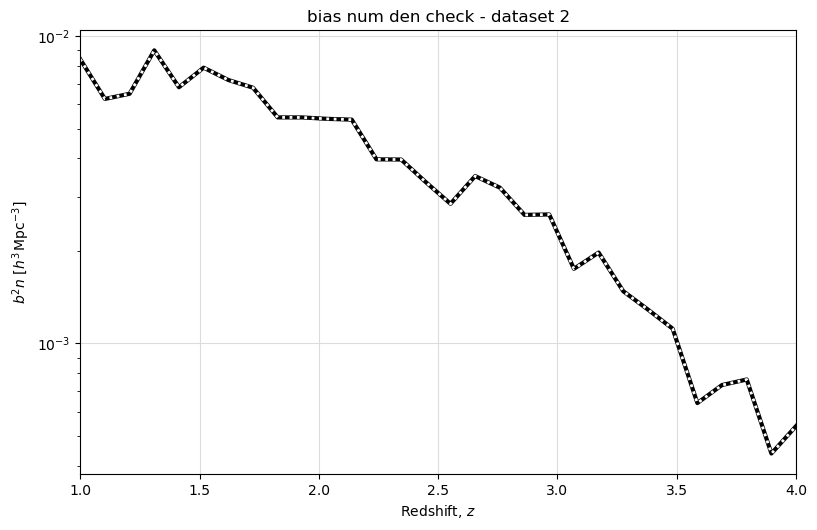

In [195]:
def ELGb(z):
    D = cosmo.scale_independent_growth_factor(z)
    return 0.84/(D)

plt.figure(figsize = (8,5))
plt.semilogy(z_tot_test, np.array([SIRMOS_2.b(z) for z in z_tot_test])**2 * [SIRMOS_2.n(z) for z in z_tot_test], c = 'black', linewidth = 3)
plt.semilogy(z_tot_test, np.array([ELGb(z) for z in z_tot_test])**2 * [n_sirmos_2(z) for z in z_tot_test], linestyle = ':', linewidth = 2, c = 'white')
plt.xlim(1,4)
plt.grid(c='gainsboro')
plt.tight_layout()
plt.xlabel(f'Redshift, $z$')
plt.ylabel('$b^2n \, \,[h^3 \, \mathrm{Mpc}^{-3}]$')
plt.title('bias num den check - dataset 2')
plt.show()


In [196]:
def error_ellipse(ax, xc, yc, cov, sigma, facecolor='none', edgecolor='black', linewidth=3, linestyle='-', **kwargs):
    '''
    Plot an error ellipse contour over your data.
    Inputs:
    ax : matplotlib Axes() object
    xc : x-coordinate of ellipse center
    yc : y-coordinate of ellipse center
    cov : covariance matrix
    sigma : # sigma to plot (default 1)
    facecolor : fill color of the ellipse (default 'none')
    edgecolor : edge color of the ellipse (default 'black')
    linewidth : width of the ellipse edge (default 2)
    linestyle : style of the ellipse edge (default '-')
    additional kwargs passed to matplotlib.patches.Ellipse()
    '''
    w, v = np.linalg.eigh(cov)  # assumes symmetric matrix
    order = w.argsort()[::-1]
    w, v = w[order], v[:, order]
    theta = np.degrees(np.arctan2(*v[:, 0][::-1]))
    ellipse = Ellipse(xy=(xc, yc),
                      width=2. * sigma * np.sqrt(w[0]),
                      height=2. * sigma * np.sqrt(w[1]),
                      angle=theta, facecolor=facecolor, edgecolor=edgecolor, linewidth=linewidth, linestyle=linestyle, **kwargs)
    ax.add_patch(ellipse)

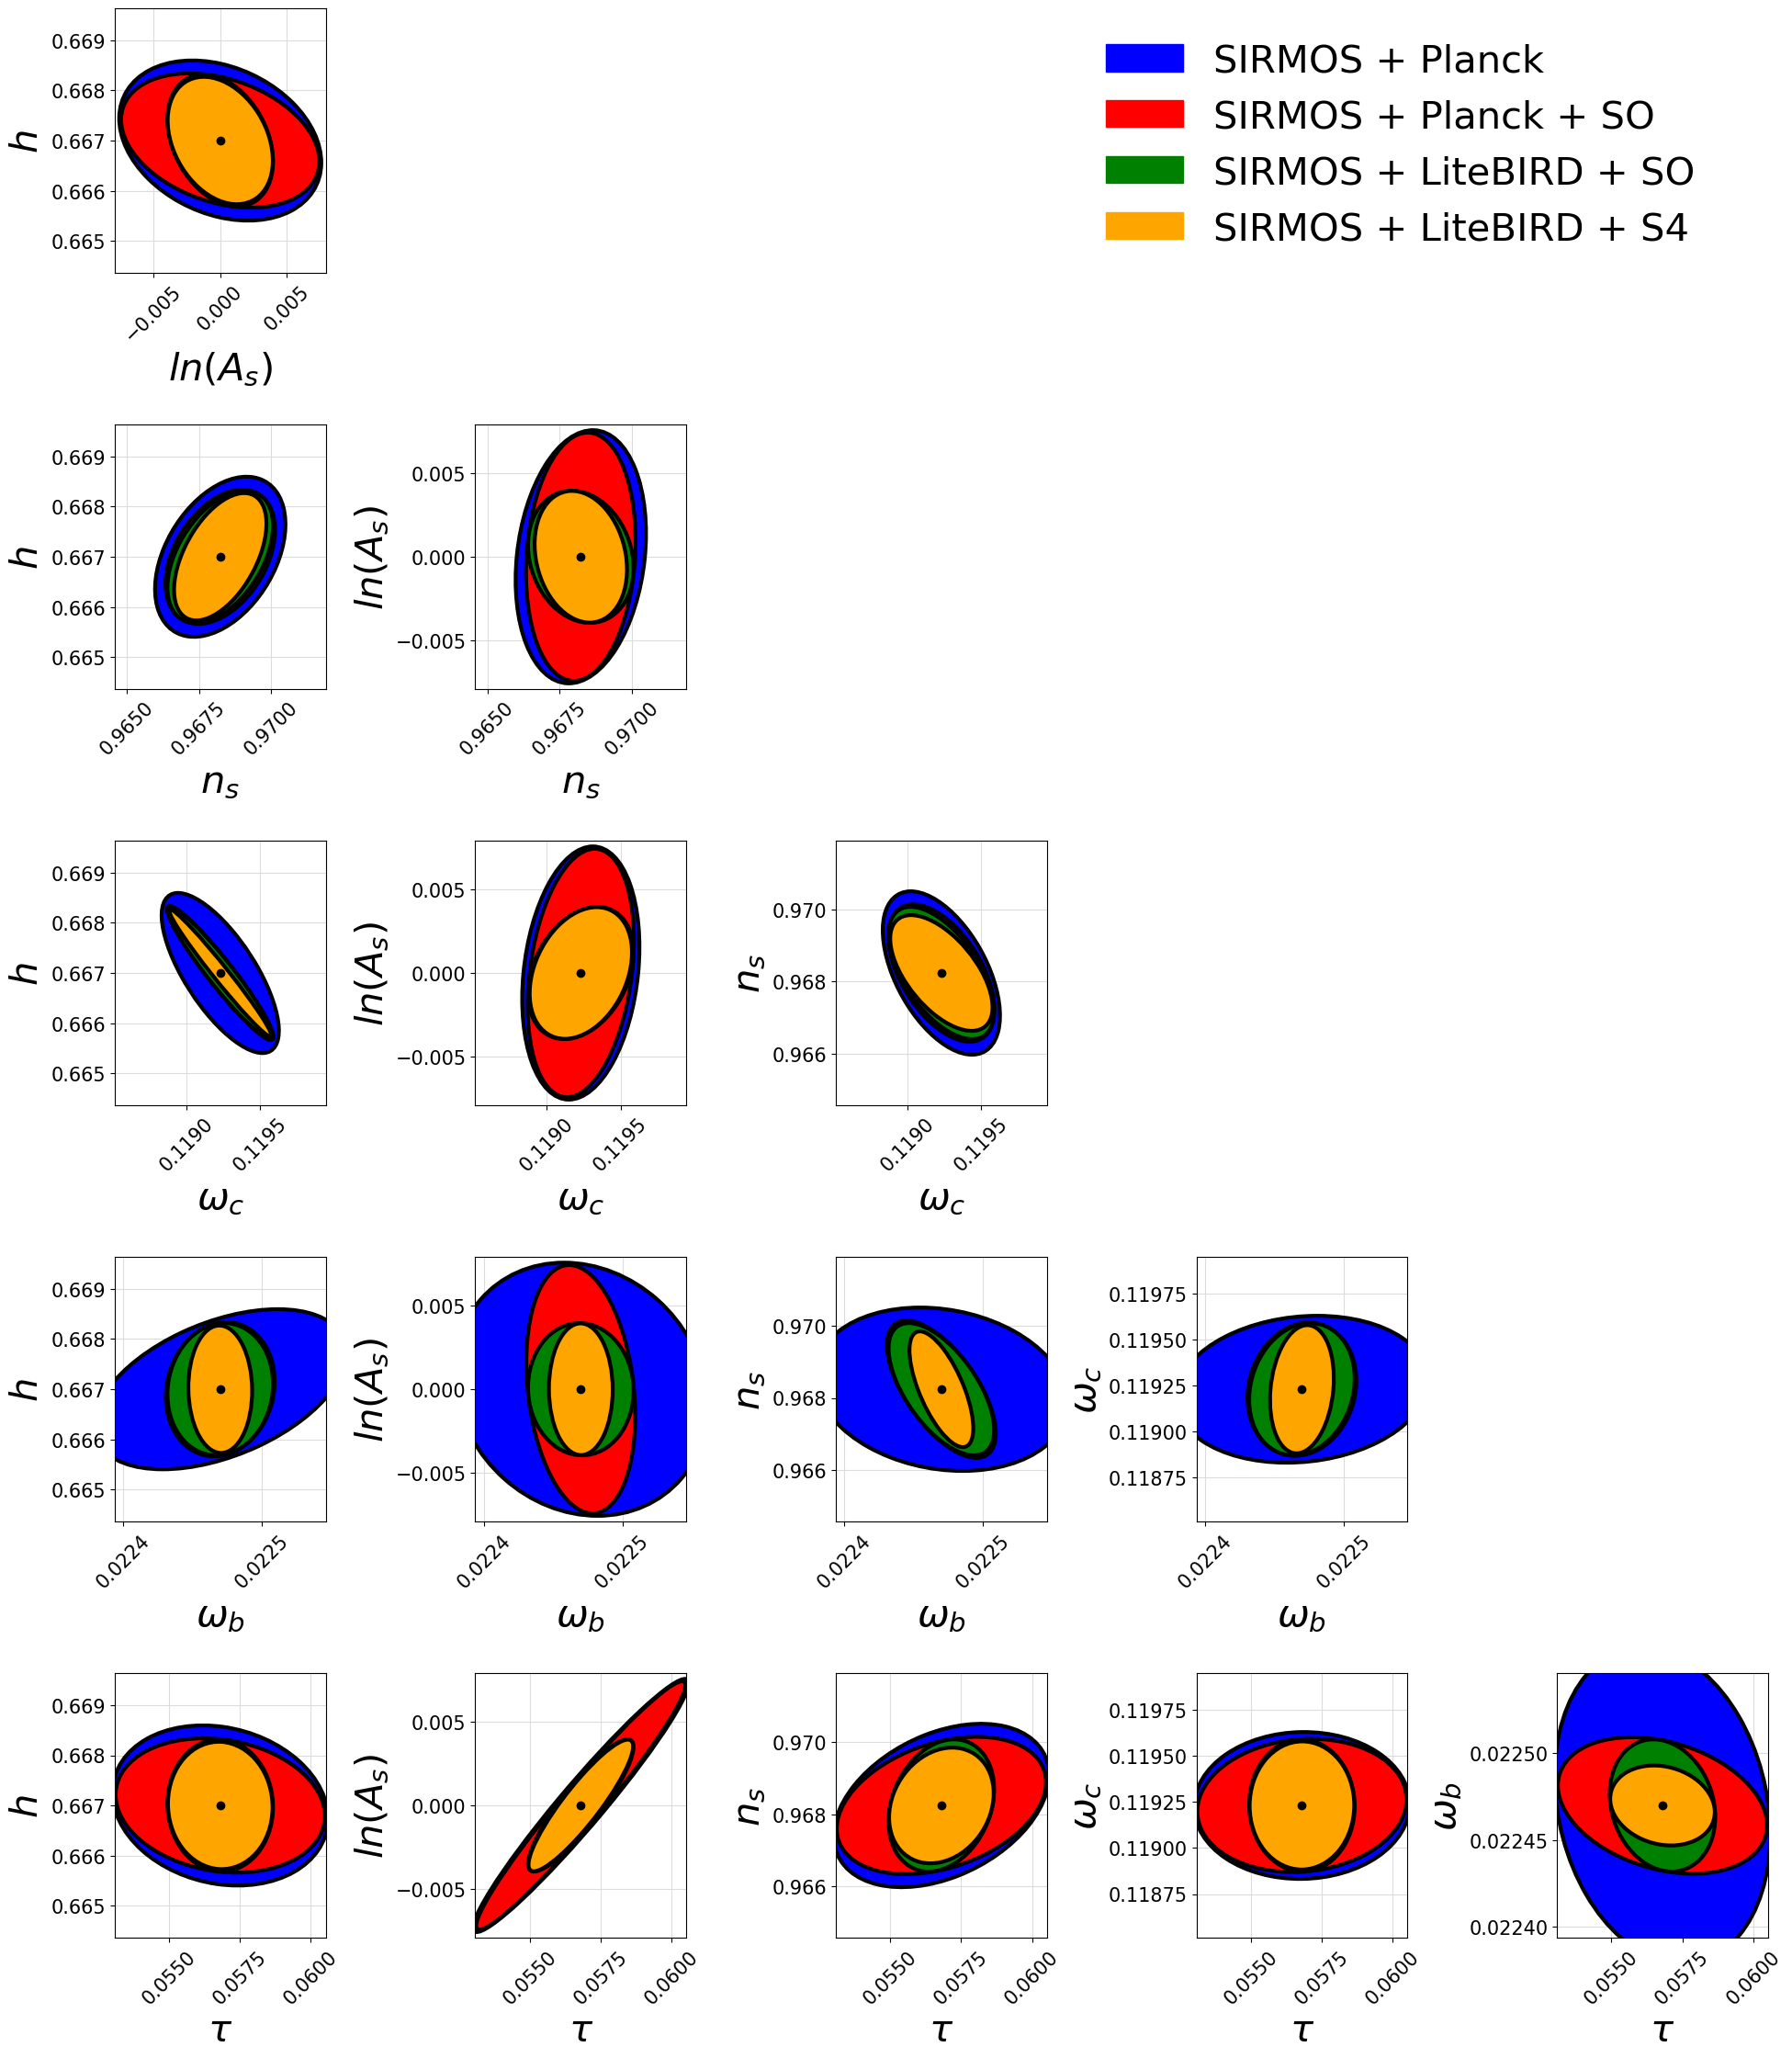

In [197]:
#WITHOUT LENSING - SIRMOS ONLY
if 'm_ncdm' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$M_{ν}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0.06]
    
    fisher_matrix_1 = F_planck_sirmos_2
    fisher_matrix_2 = F_planck_SO_sirmos_2
    fisher_matrix_3 = F_litebird_SO_sirmos_2
    fisher_matrix_4 = F_litebird_S4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6]+' [eV]', fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_without_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()

    
elif 'N_eff' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$N_{\mathrm{eff}}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 3.014]
    
    fisher_matrix_1 = F_planck_sirmos_2
    fisher_matrix_2 = F_planck_SO_sirmos_2
    fisher_matrix_3 = F_litebird_SO_sirmos_2
    fisher_matrix_4 = F_litebird_S4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_without_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()
    
elif 'Omega_k' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$\Omega_k$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0.0]
    
    fisher_matrix_1 = F_planck_sirmos_2
    fisher_matrix_2 = F_planck_SO_sirmos_2
    fisher_matrix_3 = F_litebird_SO_sirmos_2
    fisher_matrix_4 = F_litebird_S4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_without_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()

    
elif 'f_NL' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$f_{NL}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0]
    
    fisher_matrix_1 = F_planck_sirmos_2
    fisher_matrix_2 = F_planck_SO_sirmos_2
    fisher_matrix_3 = F_litebird_SO_sirmos_2
    fisher_matrix_4 = F_litebird_S4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_without_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()
    
    
else:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568]
    
    fisher_matrix_1 = F_planck_sirmos_2
    fisher_matrix_2 = F_planck_SO_sirmos_2
    fisher_matrix_3 = F_litebird_SO_sirmos_2
    fisher_matrix_4 = F_litebird_S4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)
    
    n_params = len(non_redshift_dep)

    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(n_params-1, n_params-1, figsize = (20,20))
    for i in range(n_params):
        for j in range(i):
            ax = axes[i-1, j]
            mean_x = mean_values[i]
            mean_y = mean_values[j]

            sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, j], [i, j])]
            sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, j], [i, j])]
            sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, j], [i, j])]
            sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, j], [i, j])]

            sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

            for k in [0,1,2,3]: 
                error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor = colours[k])

            ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
            ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
            ax.set_xlabel(names[i], fontsize = 30)
            ax.set_ylabel(names[j], fontsize = 30)
            ax.tick_params(axis='x', rotation=45, labelsize = 15)
            ax.tick_params(axis='y', labelsize = 15)
            ax.grid(c='gainsboro')
            ax.scatter(mean_x, mean_y, color='black')

    for i in range(n_params - 1):
        for j in range(i + 1, n_params - 1):
            fig.delaxes(axes[i, j])

    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.75, 1.1), ncol=1, fontsize="30", frameon=False)
    plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.rc('axes', axisbelow=True)
    plt.savefig('sirmos_plus_priors_without_lensing_no_ext.pdf', bbox_inches='tight')  
    plt.show()

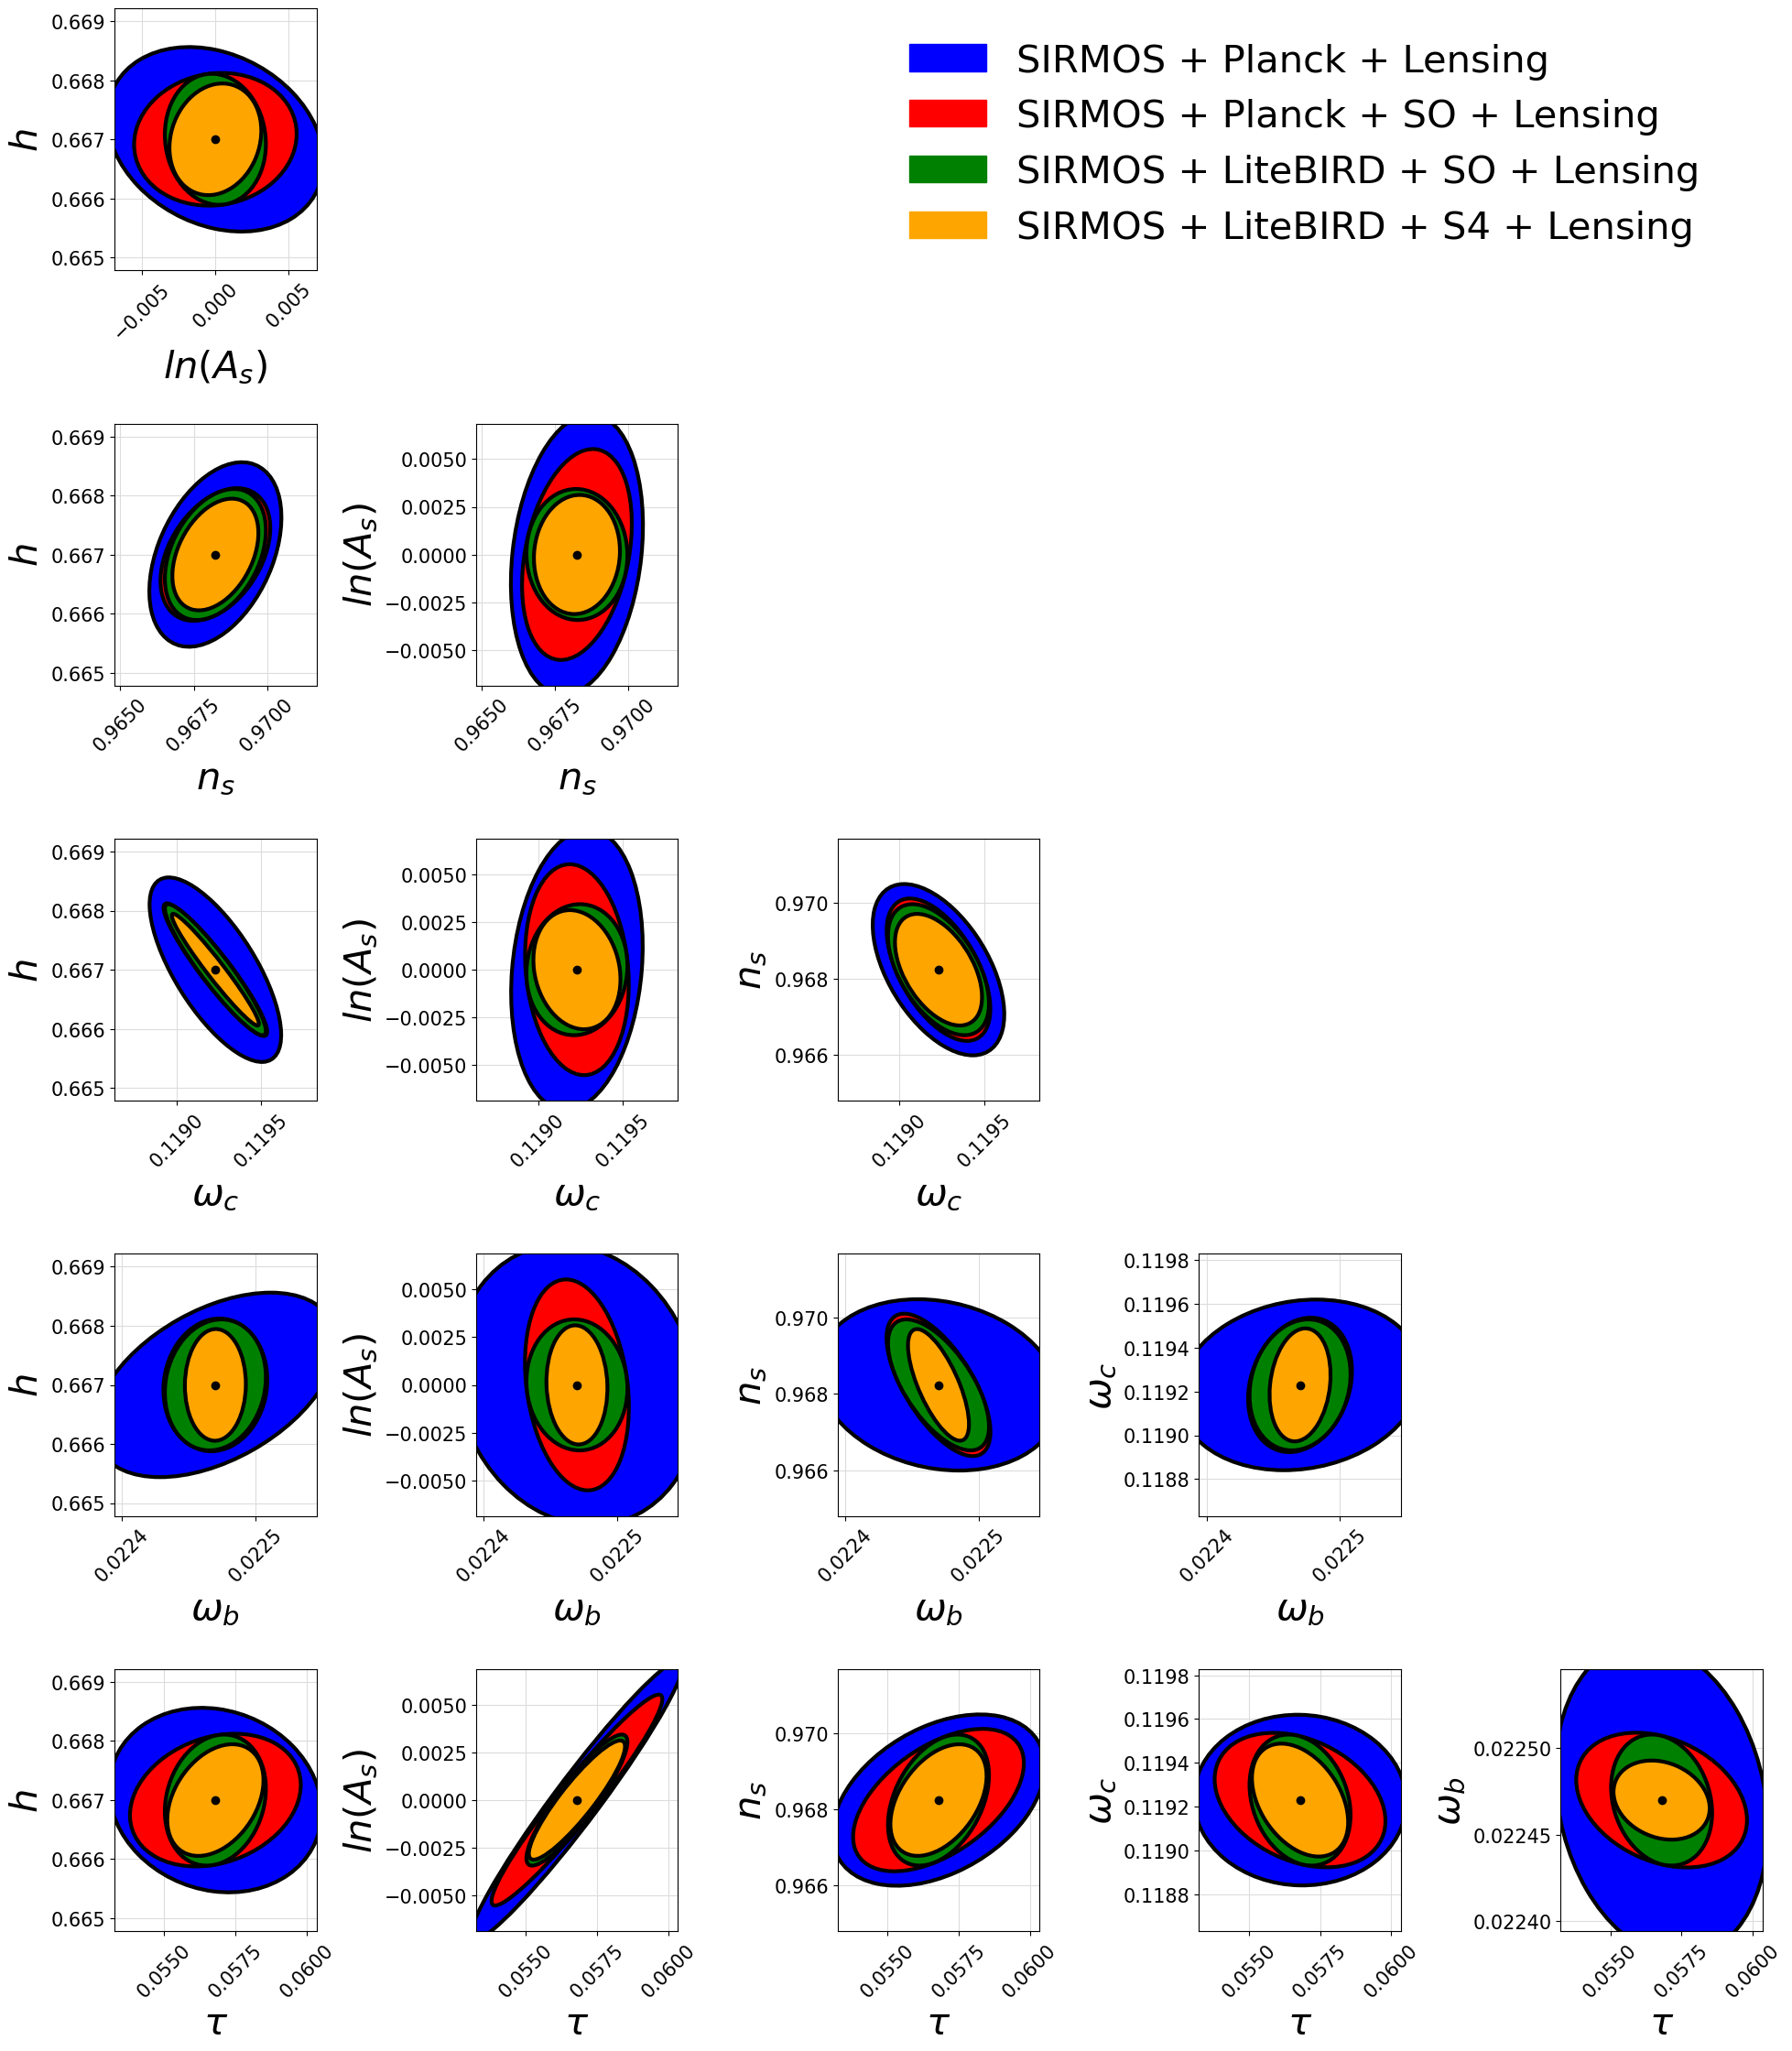

In [198]:
#WITH LENSING - SIRMOS ONLY
if 'm_ncdm' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$M_{ν}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0.06]
    
    fisher_matrix_1 = F_Pkmu_Cl_Planck_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2
    fisher_matrix_3 = F_Pkmu_Cl_litebird_so_sirmos_2
    fisher_matrix_4 = F_Pkmu_Cl_litebird_s4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + Lensing')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO + Lensing')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO + Lensing')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4 + Lensing')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_with_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()


    
elif 'N_eff' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$N_{\mathrm{eff}}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 3.014]
    
    fisher_matrix_1 = F_Pkmu_Cl_Planck_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2
    fisher_matrix_3 = F_Pkmu_Cl_litebird_so_sirmos_2
    fisher_matrix_4 = F_Pkmu_Cl_litebird_s4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + Lensing')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO + Lensing')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO + Lensing')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4 + Lensing')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_with_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()

    
elif 'Omega_k' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$\Omega_k$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0.0]
    
    fisher_matrix_1 = F_Pkmu_Cl_Planck_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2
    fisher_matrix_3 = F_Pkmu_Cl_litebird_so_sirmos_2
    fisher_matrix_4 = F_Pkmu_Cl_litebird_s4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + Lensing')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO + Lensing')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO + Lensing')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4 + Lensing')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_with_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()


    
elif 'f_NL' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$f_{NL}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0]
    
    fisher_matrix_1 = F_Pkmu_Cl_Planck_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2
    fisher_matrix_3 = F_Pkmu_Cl_litebird_so_sirmos_2
    fisher_matrix_4 = F_Pkmu_Cl_litebird_s4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

        for k in range(4):
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
        ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6], fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + Lensing')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO + Lensing')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO + Lensing')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4 + Lensing')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_plus_priors_with_lensing_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()

    
else:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568]
    
    fisher_matrix_1 = F_Pkmu_Cl_Planck_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2
    fisher_matrix_3 = F_Pkmu_Cl_litebird_so_sirmos_2
    fisher_matrix_4 = F_Pkmu_Cl_litebird_s4_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)
    cov_matrix_3 = np.linalg.inv(fisher_matrix_3)
    cov_matrix_4 = np.linalg.inv(fisher_matrix_4)

    n_params = len(non_redshift_dep)

    colours = ['blue', 'red', 'green', 'orange']

    fig, axes = plt.subplots(n_params-1, n_params-1, figsize = (20,20))
    for i in range(n_params):
        for j in range(i):
            ax = axes[i-1, j]
            mean_x = mean_values[i]
            mean_y = mean_values[j]

            sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, j], [i, j])]
            sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, j], [i, j])]
            sub_cov_matrix_3 = cov_matrix_3[np.ix_([i, j], [i, j])]
            sub_cov_matrix_4 = cov_matrix_4[np.ix_([i, j], [i, j])]

            sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2, sub_cov_matrix_3, sub_cov_matrix_4]

            for k in [0,1,2,3]: 
                error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor = colours[k])

            ax.set_xlim(mean_x - 2 * np.sqrt(sub_cov_matrix_3[0, 0]), mean_x + 2 * np.sqrt(sub_cov_matrix_3[0, 0]))
            ax.set_ylim(mean_y - 2 * np.sqrt(sub_cov_matrix_3[1, 1]), mean_y + 2 * np.sqrt(sub_cov_matrix_3[1, 1]))
            ax.set_xlabel(names[i], fontsize = 30)
            ax.set_ylabel(names[j], fontsize = 30)
            ax.tick_params(axis='x', rotation=45, labelsize = 15)
            ax.tick_params(axis='y', labelsize = 15)
            ax.grid(c='gainsboro')
            ax.scatter(mean_x, mean_y, color='black')

    for i in range(n_params - 1):
        for j in range(i + 1, n_params - 1):
            fig.delaxes(axes[i, j])

    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + Lensing')
    red_patch = mpatches.Patch(color='red', label='SIRMOS + Planck + SO + Lensing')
    green_patch = mpatches.Patch(color='green', label='SIRMOS + LiteBIRD + SO + Lensing')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + LiteBIRD + S4 + Lensing')

    fig.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.7, 1.1), ncol=1, fontsize="30", frameon=False)
    plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.rc('axes', axisbelow=True)
    plt.savefig('sirmos_plus_priors_with_lensing_no_ext.pdf', bbox_inches='tight')  
    plt.show()

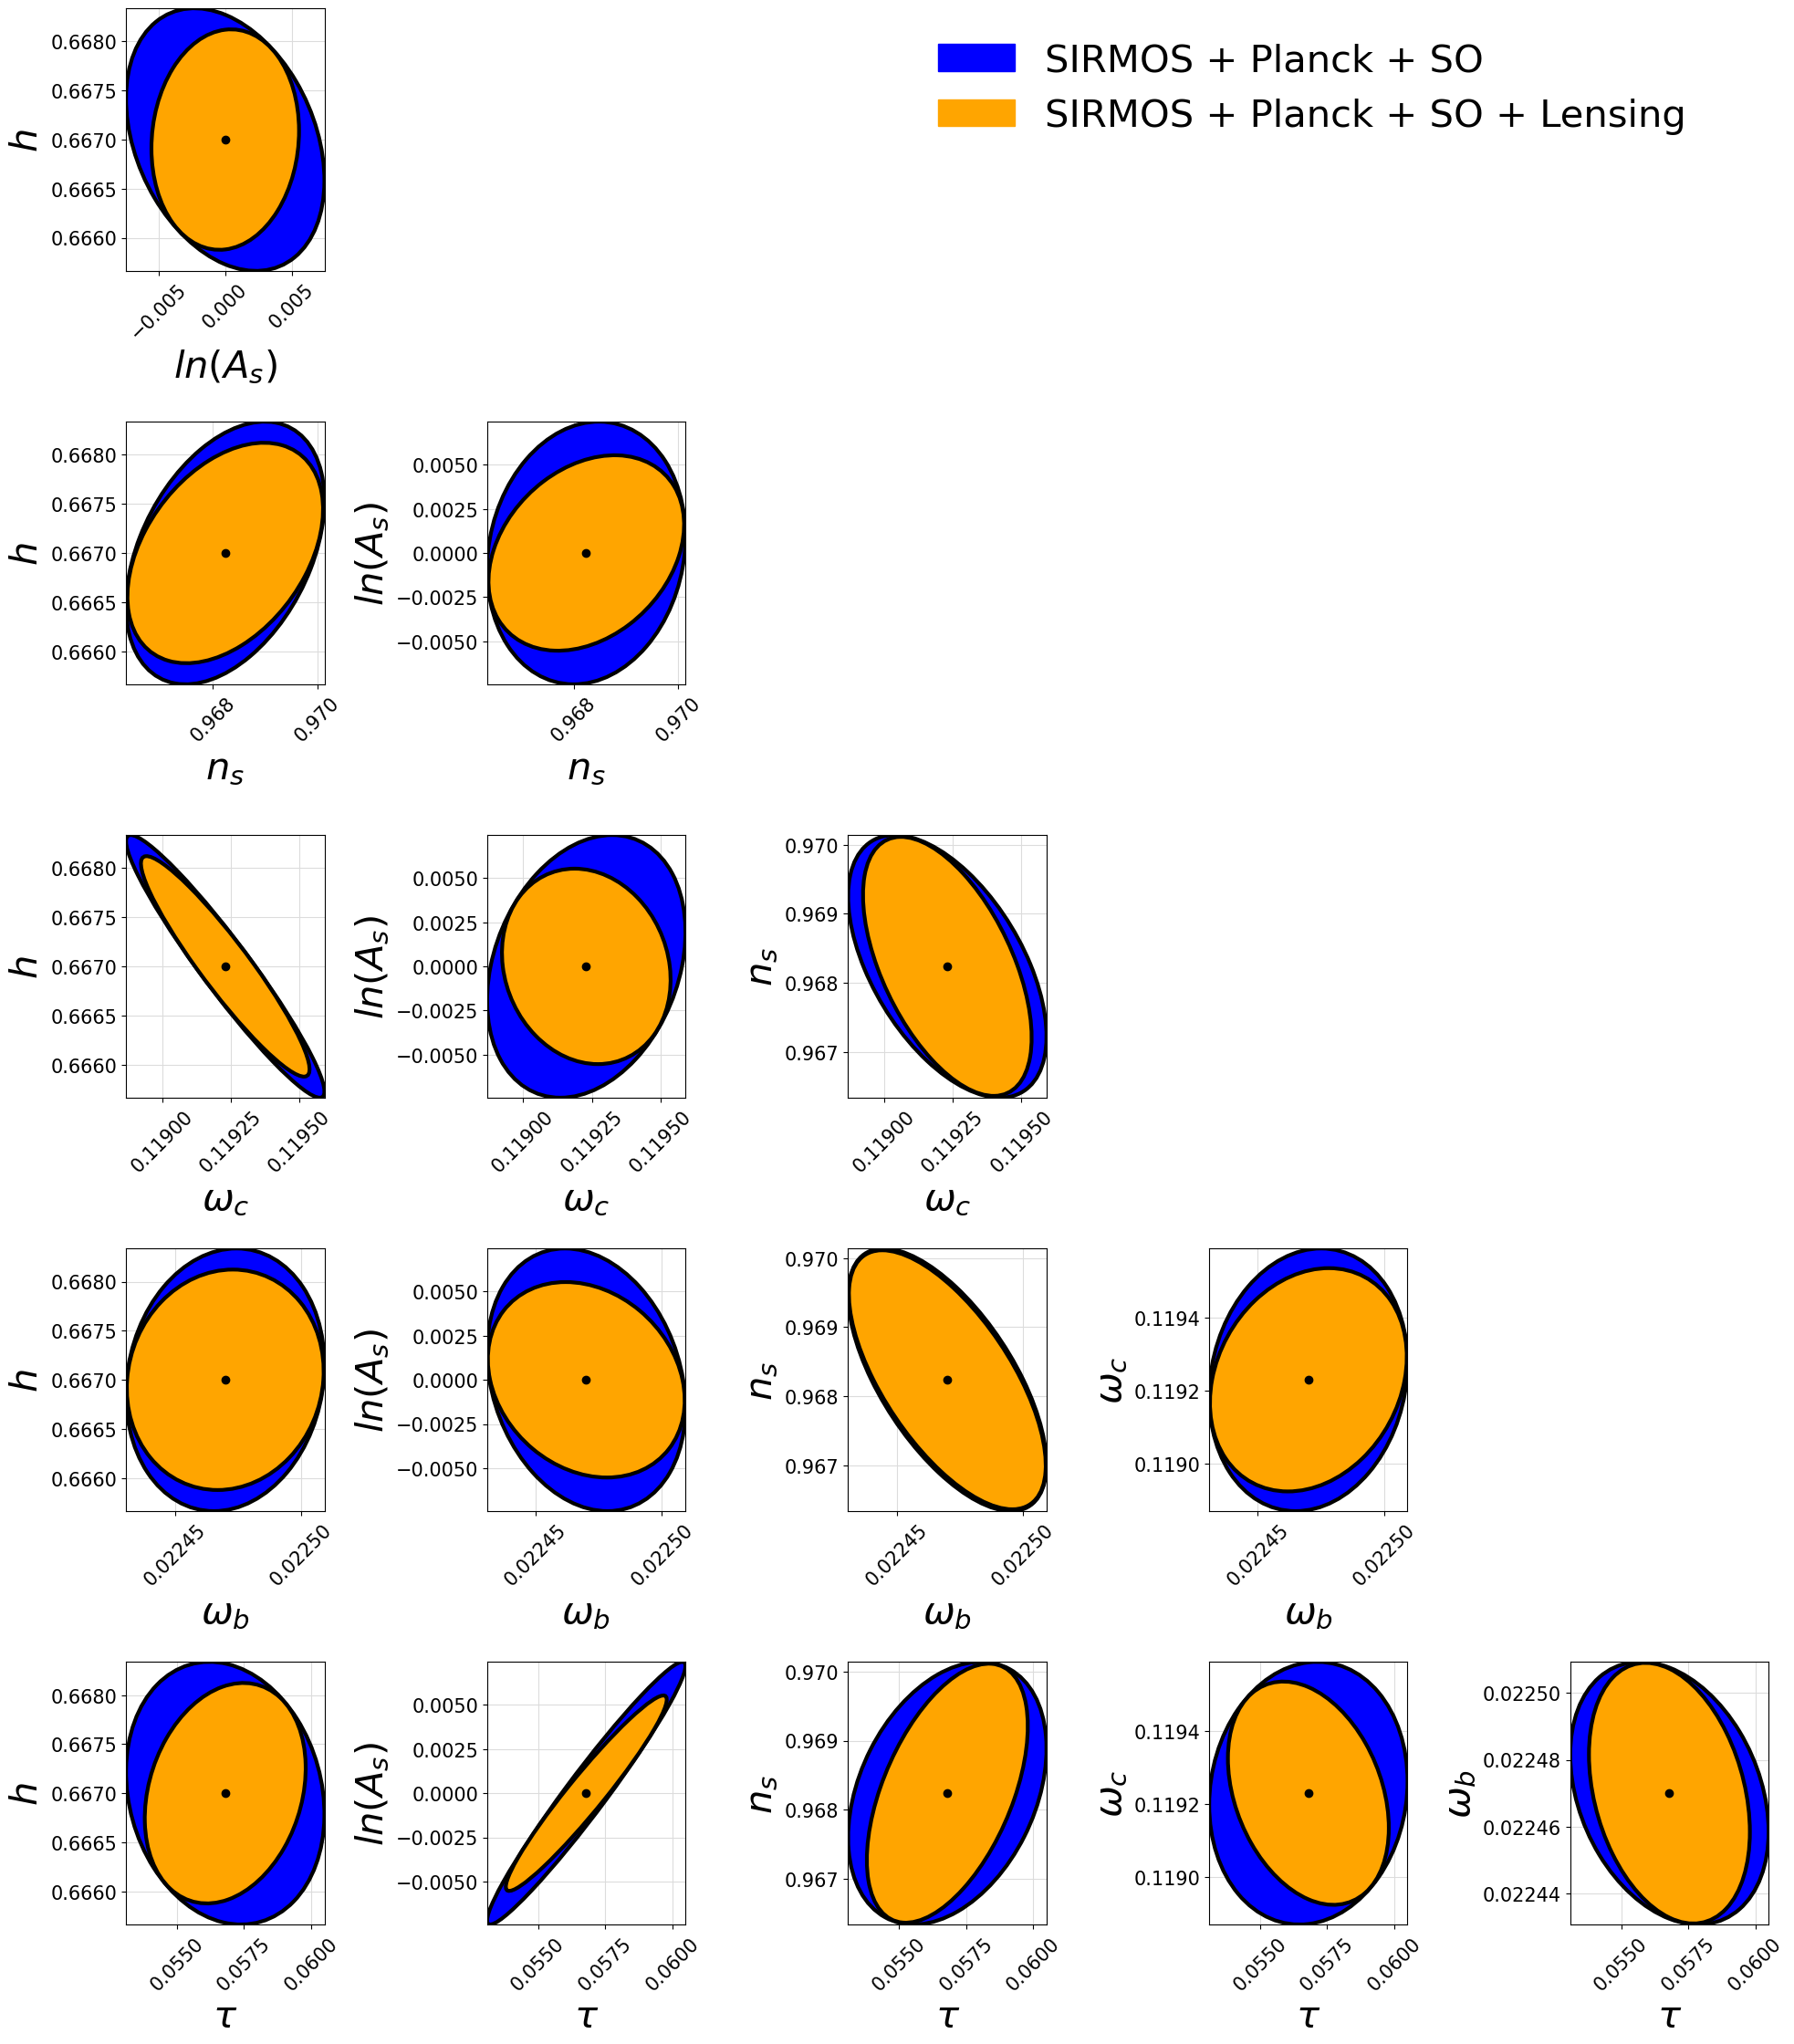

In [199]:
if 'm_ncdm' in non_redshift_dep:
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$", "$M_{ν}$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568, 0.06]
    
    fisher_matrix_1 = F_planck_SO_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)

    n_params = len(non_redshift_dep)
    colours = ['blue', 'orange',]

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    for idx, i in enumerate(range(6)):
        ax = axes[idx % 2, idx // 2]
        mean_x = mean_values[i]
        mean_y = mean_values[6]

        sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, 6], [i, 6])]
        sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, 6], [i, 6])]

        sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2]

        for k in [0,1]:
            error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor=colours[k])

        ax.set_xlim(mean_x - np.sqrt(sub_cov_matrix_1[0, 0]), mean_x + np.sqrt(sub_cov_matrix_1[0, 0]))
        ax.set_ylim(mean_y - np.sqrt(sub_cov_matrix_1[1, 1]), mean_y + np.sqrt(sub_cov_matrix_1[1, 1]))
        ax.set_xlabel(names[i], fontsize = 45)
        ax.set_ylabel(names[6] + ' [eV]', fontsize = 45)
        ax.tick_params(axis='x', rotation= 45, labelsize = 20)
        ax.tick_params(axis='y', labelsize = 20)
        ax.grid(c='gainsboro')
        ax.scatter(mean_x, mean_y, color='black')


    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + Planck + SO + Lensing')

    fig.legend(handles=[blue_patch, orange_patch], loc = 'upper center', bbox_to_anchor=(0.5, 1.3),  ncol=2, fontsize="35", frameon=False)
    plt.rc('axes', axisbelow=True)
    plt.tight_layout(pad=2.5, h_pad=1.5, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.savefig('sirmos_planck_so_param_degen_break_'+non_redshift_dep[6]+'.pdf', bbox_inches='tight') 
    plt.show()

param_to_check = ['m_ncdm', 'N_eff', 'Omega_k', 'f_NL']
if all(param not in non_redshift_dep for param in param_to_check):
    names = ["$h$", "$ln(A_s)$", "$n_s$", "$\omega_c$", "$\omega_b$", "$τ$"]
    mean_values = [0.667, 2.10732e-9, 0.96824, 0.11923, 0.02247, 0.0568]
    
    fisher_matrix_1 = F_planck_SO_sirmos_2
    fisher_matrix_2 = F_Pkmu_Cl_Planck_SO_sirmos_2

    cov_matrix_1 = np.linalg.inv(fisher_matrix_1)
    cov_matrix_2 = np.linalg.inv(fisher_matrix_2)

    n_params = len(non_redshift_dep)

    colours = ['blue', 'orange']

    fig, axes = plt.subplots(n_params-1, n_params-1, figsize = (20,20))
    for i in range(n_params):
        for j in range(i):
            ax = axes[i-1, j]
            mean_x = mean_values[i]
            mean_y = mean_values[j]

            sub_cov_matrix_1 = cov_matrix_1[np.ix_([i, j], [i, j])]
            sub_cov_matrix_2 = cov_matrix_2[np.ix_([i, j], [i, j])]

            sub_cov_matrix_all = [sub_cov_matrix_1, sub_cov_matrix_2]

            for k in [0,1]: 
                error_ellipse(ax, mean_x, mean_y, sub_cov_matrix_all[k], sigma=1, facecolor = colours[k])

            ax.set_xlim(mean_x - np.sqrt(sub_cov_matrix_1[0, 0]), mean_x + np.sqrt(sub_cov_matrix_1[0, 0]))
            ax.set_ylim(mean_y - np.sqrt(sub_cov_matrix_1[1, 1]), mean_y + np.sqrt(sub_cov_matrix_1[1, 1]))
            ax.set_xlabel(names[i], fontsize = 30)
            ax.set_ylabel(names[j], fontsize = 30)
            ax.tick_params(axis='x', rotation=45, labelsize = 15)
            ax.tick_params(axis='y', labelsize = 15)
            ax.grid(c='gainsboro')
            ax.scatter(mean_x, mean_y, color='black')

    for i in range(n_params - 1):
        for j in range(i + 1, n_params - 1):
            fig.delaxes(axes[i, j])

    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO')
    orange_patch = mpatches.Patch(color='orange', label='SIRMOS + Planck + SO + Lensing')

    fig.legend(handles=[blue_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.7, 1.1), ncol=1, fontsize="30", frameon=False)
    plt.tight_layout(pad=2.0, h_pad=1.0, w_pad=1.0)
    plt.subplots_adjust(left=0.05, right=0.95, top=1.1, bottom=0.05)  
    plt.rc('axes', axisbelow=True)
    plt.savefig('sirmos_planck_so_param_degen_break.pdf', bbox_inches='tight')  
    plt.show()

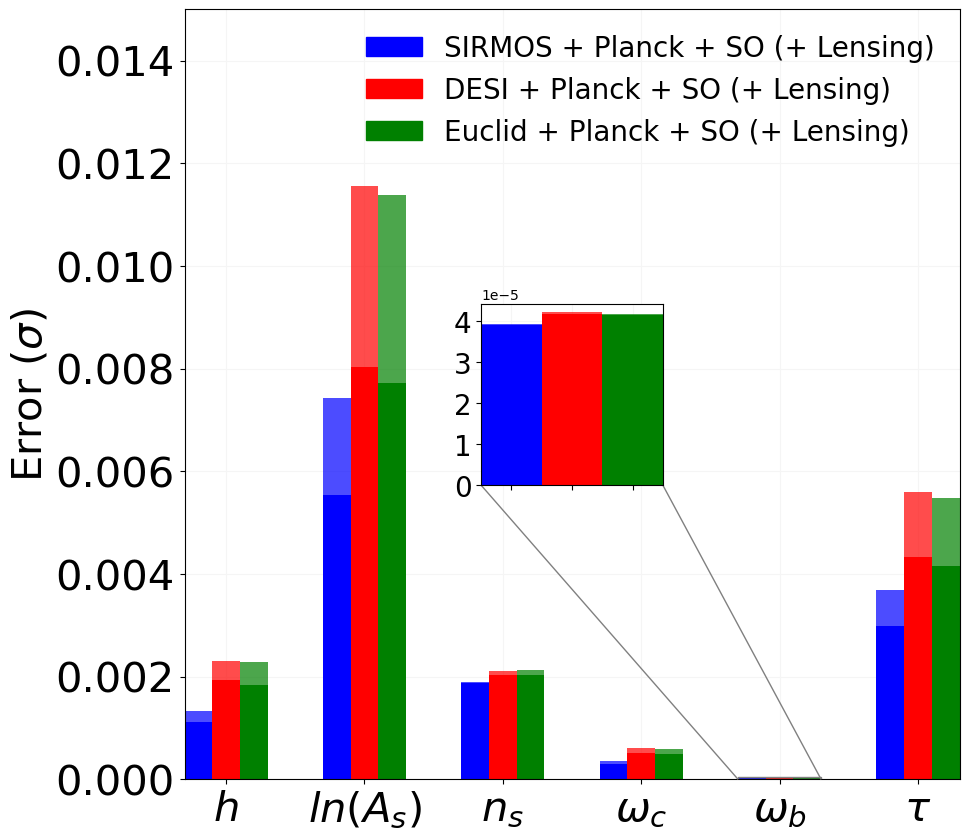

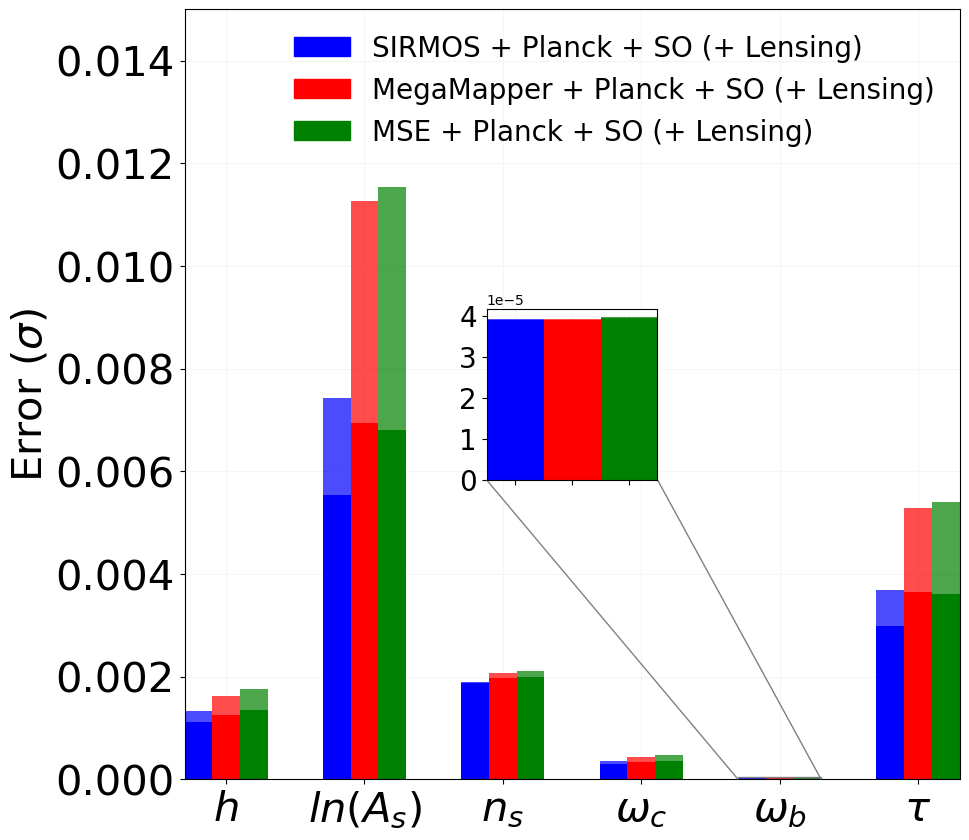

In [200]:
if 'f_NL' in non_redshift_dep:
    fisher_matrix_1 = [F_Pkmu_sirmos_2_m_ncdm, F_Pkmu_sirmos_2_n_eff, F_Pkmu_sirmos_2_omega_k, F_Pkmu_sirmos_2_f_nl]
    fisher_matrix_2 = [F_Pkmu_desi_m_ncdm, F_Pkmu_desi_n_eff, F_Pkmu_desi_omega_k, F_Pkmu_desi_f_nl]
    fisher_matrix_3 = [F_Pkmu_euclid_m_ncdm, F_Pkmu_euclid_n_eff, F_Pkmu_euclid_omega_k, F_Pkmu_euclid_f_nl]
    fisher_matrix_4 = [F_Pkmu_Cl_sirmos_2_m_ncdm, F_Pkmu_Cl_sirmos_2_n_eff, F_Pkmu_Cl_sirmos_2_omega_k, F_Pkmu_Cl_sirmos_2_f_nl]
    fisher_matrix_5 = [F_Pkmu_Cl_desi_m_ncdm, F_Pkmu_Cl_desi_n_eff, F_Pkmu_Cl_desi_omega_k, F_Pkmu_Cl_desi_f_nl]
    fisher_matrix_6 = [F_Pkmu_Cl_euclid_m_ncdm, F_Pkmu_Cl_euclid_n_eff, F_Pkmu_Cl_euclid_omega_k, F_Pkmu_Cl_euclid_f_nl]
    
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_xlim(-0.3, 3.3)
    
    for i in range(4):
        if i in [0,1,2]:
            ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6], width = 0.2, color = 'b', alpha = 0.7)
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6], width = 0.2, color='r', alpha = 0.7)    
            ax.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6], width = 0.2, color='g', alpha = 0.7)
            ax.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6], width = 0.2, color = 'b')
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6], width = 0.2, color='r')    
            ax.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6], width = 0.2, color='g')

        if i ==3:
            ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6] *10**(-1), width = 0.2, color = 'b', alpha = 0.7)
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6] *10**(-1), width = 0.2, color='r', alpha = 0.7)    
            ax.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6] *10**(-1), width = 0.2, color='g', alpha = 0.7)
            ax.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6] *10**(-1), width = 0.2, color = 'b')
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6] *10**(-1), width = 0.2, color='r')    
            ax.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6] *10**(-1), width = 0.2, color='g')

        if i == 2:
            axins1 = zoomed_inset_axes(ax, zoom = 500, loc = 10, borderpad = 5)
            axins1.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6], width = 0.2, color = 'b', alpha = 0.7)
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6], width = 0.2, color='r', alpha = 0.7)    
            axins1.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6], width = 0.2, color='g', alpha = 0.7)
            axins1.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6], width = 0.2, color = 'b')
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6], width = 0.2, color='r')    
            axins1.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6], width = 0.2, color='g')
            axins1.grid(c='whitesmoke')

            x1, x2 = 1.7,2.3
            axins1.set_xlim(x1, x2)
            #axins1.set_ylim(y1, y2)
            axins1.set_aspect(aspect='auto')
            axins1.set_box_aspect(1)  
            plt.xticks(visible=False)
            plt.yticks(fontsize = 20)
            mark_inset(ax, axins1, loc1=3, loc2=4, fc="none", ec='0.5')
        
    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO (+ Lensing)')
    red_patch = mpatches.Patch(color='red', label='DESI + Planck + SO (+ Lensing)')
    green_patch = mpatches.Patch(color='green', label='Euclid + Planck + SO (+ Lensing)')

    plt.rc('axes', axisbelow=True)

    ax.grid(c='whitesmoke')
    ax.legend(handles=[blue_patch, red_patch, green_patch], loc = 'upper left',prop = { "size": 20 }, frameon = False, facecolor='whitesmoke', framealpha=0.75, ncol = 1)
    ax.set_xticks([0,1,2,3], labels = ['$M_{\mathrm{ν}} \, \mathrm{[eV]}$','$N_{\mathrm{eff}}$','$\Omega_k$','$10^{-1} f_{\mathrm{NL}}$'])
    #ax.set_xlabel('Parameter', fontsize = 50)
    ax.set_ylabel('Error ($\sigma$)', fontsize = 30)
    ax.tick_params(axis='both', labelsize=30)
    plt.savefig('bar_sirmos_stage_4_with_extensions.pdf', bbox_inches='tight')
    plt.show()
    
if 'f_NL' in non_redshift_dep:
    fisher_matrix_1 = [F_Pkmu_sirmos_2_m_ncdm, F_Pkmu_sirmos_2_n_eff, F_Pkmu_sirmos_2_omega_k, F_Pkmu_sirmos_2_f_nl]
    fisher_matrix_2 = [F_Pkmu_mm_m_ncdm, F_Pkmu_mm_n_eff, F_Pkmu_mm_omega_k, F_Pkmu_mm_f_nl]
    fisher_matrix_3 = [F_Pkmu_mse_m_ncdm, F_Pkmu_mse_n_eff, F_Pkmu_mse_omega_k, F_Pkmu_mse_f_nl]
    fisher_matrix_4 = [F_Pkmu_Cl_sirmos_2_m_ncdm, F_Pkmu_Cl_sirmos_2_n_eff, F_Pkmu_Cl_sirmos_2_omega_k, F_Pkmu_Cl_sirmos_2_f_nl]
    fisher_matrix_5 = [F_Pkmu_Cl_mm_m_ncdm, F_Pkmu_Cl_mm_n_eff, F_Pkmu_Cl_mm_omega_k, F_Pkmu_Cl_mm_f_nl]
    fisher_matrix_6 = [F_Pkmu_Cl_mse_m_ncdm, F_Pkmu_Cl_mse_n_eff, F_Pkmu_Cl_mse_omega_k, F_Pkmu_Cl_mse_f_nl]

    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_xlim(-0.3, 3.3)
    ax.set_ylim(0,0.2)
    
    for i in range(4):
        if i in [0,1,2]:
            ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6], width = 0.2, color = 'b', alpha = 0.7)
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6], width = 0.2, color='r', alpha = 0.7)    
            ax.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6], width = 0.2, color='g', alpha = 0.7)
            ax.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6], width = 0.2, color = 'b')
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6], width = 0.2, color='r')    
            ax.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6], width = 0.2, color='g')

        if i ==3:
            ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6] *10**(-1), width = 0.2, color = 'b', alpha = 0.7)
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6] *10**(-1), width = 0.2, color='r', alpha = 0.7)    
            ax.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6] *10**(-1), width = 0.2, color='g', alpha = 0.7)
            ax.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6] *10**(-1), width = 0.2, color = 'b')
            ax.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6] *10**(-1), width = 0.2, color='r')    
            ax.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6] *10**(-1), width = 0.2, color='g')

        if i == 2:
            axins1 = zoomed_inset_axes(ax, zoom = 150, loc = 10, borderpad = 5)
            axins1.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1[i])))[6], width = 0.2, color = 'b', alpha = 0.7)
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2[i])))[6], width = 0.2, color='r', alpha = 0.7)    
            axins1.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3[i])))[6], width = 0.2, color='g', alpha = 0.7)
            axins1.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4[i])))[6], width = 0.2, color = 'b')
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5[i])))[6], width = 0.2, color='r')    
            axins1.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6[i])))[6], width = 0.2, color='g')
            axins1.grid(c='whitesmoke')

            x1, x2 = 1.7,2.3
            axins1.set_xlim(x1, x2)
            #axins1.set_ylim(y1, y2)
            axins1.set_aspect(aspect='auto')
            axins1.set_box_aspect(1)  
            plt.xticks(visible=False)
            plt.yticks(fontsize = 20)
            mark_inset(ax, axins1, loc1=3, loc2=4, fc="none", ec='0.5')
        
    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO (+ Lensing)')
    red_patch = mpatches.Patch(color='red', label='MegaMapper + Planck + SO (+ Lensing)')
    green_patch = mpatches.Patch(color='green', label='MSE + Planck + SO (+ Lensing)')

    plt.rc('axes', axisbelow=True)

    ax.grid(c='whitesmoke')
    ax.legend(handles=[blue_patch, red_patch, green_patch], loc = 'upper left',prop = { "size": 20 }, frameon = False, facecolor='whitesmoke', framealpha=0.75, ncol = 1)
    ax.set_xticks([0,1,2,3], labels = ['$M_{\mathrm{ν}} \, \mathrm{[eV]}$','$N_{\mathrm{eff}}$','$\Omega_k$','$10^{-1} f_{\mathrm{NL}}$'])
    #ax.set_xlabel('Parameter', fontsize = 30)
    ax.set_ylabel('Error ($\sigma$)', fontsize = 30)
    ax.tick_params(axis='both', labelsize=30)
    plt.savefig('bar_sirmos_stage_5_with_extensions.pdf', bbox_inches='tight')
    plt.show()

else:
    fisher_matrix_1 = F_Pkmu_sirmos_2_no_ext
    fisher_matrix_2 = F_Pkmu_desi_no_ext
    fisher_matrix_3 = F_Pkmu_euclid_no_ext
    fisher_matrix_4 = F_Pkmu_Cl_sirmos_2_no_ext
    fisher_matrix_5 = F_Pkmu_Cl_desi_no_ext
    fisher_matrix_6 = F_Pkmu_Cl_euclid_no_ext
    
    fig,ax = plt.subplots(figsize=(10,10))

    for i in range(n_params):
        ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1)))[i], width = 0.2, color = 'b', alpha = 0.7)
        ax.bar(i, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2)))[i], width = 0.2, color='r', alpha = 0.7)    
        ax.bar(i+0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3)))[i], width = 0.2, color='g', alpha = 0.7)
        ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4)))[i], width = 0.2, color = 'b')
        ax.bar(i, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5)))[i], width = 0.2, color='r')    
        ax.bar(i+0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6)))[i], width = 0.2, color='g')
        ax.set_xlim(-0.3, 5.3)
        ax.set_ylim(0,0.015)
        
        if i == 4:
            axins1 = zoomed_inset_axes(ax, zoom = 80, loc = 10, borderpad = 3)
            axins1.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1)))[i], width = 0.2, color = 'b', alpha = 0.7)
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2)))[i], width = 0.2, color='r', alpha = 0.7)    
            axins1.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3)))[i], width = 0.2, color='g', alpha = 0.7)
            axins1.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4)))[i], width = 0.2, color = 'b')
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5)))[i], width = 0.2, color='r')    
            axins1.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6)))[i], width = 0.2, color='g')
            axins1.grid(c='whitesmoke')

            x1, x2 = 3.7,4.3
            axins1.set_xlim(x1, x2)
            #axins1.set_ylim(y1, y2)
            axins1.set_aspect(aspect='auto')
            axins1.set_box_aspect(1)
            plt.yticks(fontsize = 20)
            plt.xticks(visible=False)
            mark_inset(ax, axins1, loc1=3, loc2=4, fc="none", ec = '0.5')

    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO (+ Lensing)')
    red_patch = mpatches.Patch(color='red', label='DESI + Planck + SO (+ Lensing)')
    green_patch = mpatches.Patch(color='green', label='Euclid + Planck + SO (+ Lensing)')

    plt.rc('axes', axisbelow=True)

    ax.grid(c='whitesmoke')
    ax.legend(handles=[blue_patch, red_patch, green_patch], loc = 'upper right', frameon = False, facecolor='whitesmoke', framealpha=0.75, fontsize = 20, ncol = 1)
    ax.set_xticks(range(6), names[0:6])
    ax.tick_params(axis='x', labelsize = 30)
    ax.tick_params(axis='y', labelsize = 30)
    #ax.set_xlabel('Parameter', fontsize = 30)
    ax.set_ylabel('Error ($\sigma$)', fontsize = 30)
    plt.savefig('bar_sirmos_stage_4.pdf', bbox_inches='tight')
    plt.show()
    
    fisher_matrix_1 = F_Pkmu_sirmos_2_no_ext
    fisher_matrix_2 = F_Pkmu_mm_no_ext
    fisher_matrix_3 = F_Pkmu_mse_no_ext
    fisher_matrix_4 = F_Pkmu_Cl_sirmos_2_no_ext
    fisher_matrix_5 = F_Pkmu_Cl_mm_no_ext
    fisher_matrix_6 = F_Pkmu_Cl_mse_no_ext
    
    fig,ax = plt.subplots(figsize=(10,10))

    for i in range(n_params):
        ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1)))[i], width = 0.2, color = 'b', alpha = 0.7)
        ax.bar(i, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2)))[i], width = 0.2, color='r', alpha = 0.7)    
        ax.bar(i+0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3)))[i], width = 0.2, color='g', alpha = 0.7)
        ax.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4)))[i], width = 0.2, color = 'b')
        ax.bar(i, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5)))[i], width = 0.2, color='r')    
        ax.bar(i+0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6)))[i], width = 0.2, color='g')
        ax.set_xlim(-0.3, 5.3)
        ax.set_ylim(0,0.015)
            
        if i == 4:
            axins1 = zoomed_inset_axes(ax, zoom = 80, loc = 10, borderpad = 3)
            axins1.bar(i-0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_1)))[i], width = 0.2, color = 'b', alpha = 0.7)
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_2)))[i], width = 0.2, color='r', alpha = 0.7)    
            axins1.bar(i +0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_3)))[i], width = 0.2, color='g', alpha = 0.7)
            axins1.bar(i -0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_4)))[i], width = 0.2, color = 'b')
            axins1.bar(i + 0, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_5)))[i], width = 0.2, color='r')    
            axins1.bar(i + 0.2, np.sqrt(np.diag(np.linalg.inv(fisher_matrix_6)))[i], width = 0.2, color='g')
            axins1.grid(c='whitesmoke')

            x1, x2 = 3.7,4.3
            axins1.set_xlim(x1, x2)
            #axins1.set_ylim(y1, y2)
            axins1.set_aspect(aspect='auto')
            axins1.set_box_aspect(1)
            plt.yticks(fontsize = 20)
            plt.xticks(visible=False)
            mark_inset(ax, axins1, loc1=3, loc2=4, fc="none", ec='0.5')
            
    blue_patch = mpatches.Patch(color='blue', label='SIRMOS + Planck + SO (+ Lensing)')
    red_patch = mpatches.Patch(color='red', label='MegaMapper + Planck + SO (+ Lensing)')
    green_patch = mpatches.Patch(color='green', label='MSE + Planck + SO (+ Lensing)')

    plt.rc('axes', axisbelow=True)

    ax.grid(c='whitesmoke')
    ax.legend(handles=[blue_patch, red_patch, green_patch], loc = 'upper right', frameon = False, facecolor='whitesmoke', framealpha=0.75, fontsize = 20, ncol = 1)
    ax.set_xticks(range(6), names[0:6])
    ax.tick_params(axis='x', labelsize = 30)
    ax.tick_params(axis='y', labelsize = 30)
    #ax.set_xlabel('Parameter', fontsize = 30)
    ax.set_ylabel('Error ($\sigma$)', fontsize = 30)
    plt.savefig('bar_sirmos_stage_5.pdf', bbox_inches='tight')
    plt.show()

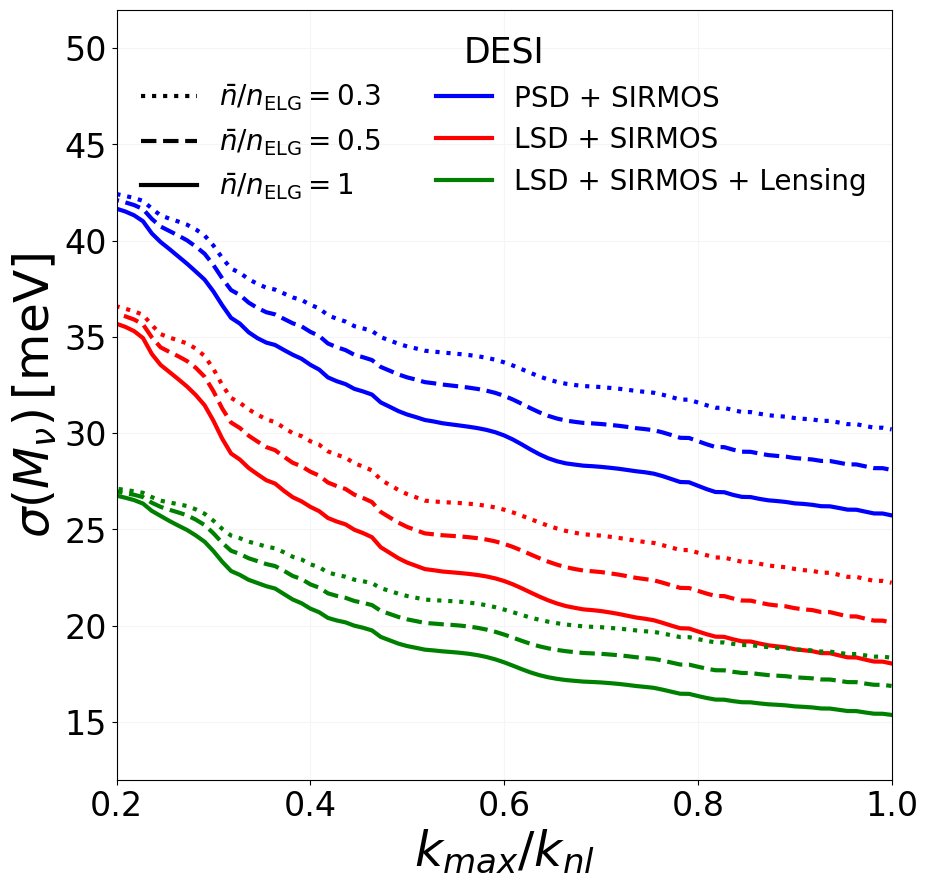

In [201]:
n_sirmos_2 = interp1d(z_tot_test, n_tot_sirmos_2)
n_sirmos_2_03 = interp1d(z_tot_test, (0.3) * n_tot_sirmos_2)
n_sirmos_2_05 = interp1d(z_tot_test, (0.5) * n_tot_sirmos_2)

SIRMOS_to_vary = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
SIRMOS_to_vary_03 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_03)
SIRMOS_to_vary_05 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_05)
DESI_to_vary = experiment(zmin = 0.6, zmax = 1.7, nbins = 4, ELG = True, fsky = 0.34)

sirmosCast_to_vary = fisherForecast(experiment = SIRMOS_to_vary, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
sirmosCast_to_vary_03 = fisherForecast(experiment = SIRMOS_to_vary_03, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_03')
sirmosCast_to_vary_05 = fisherForecast(experiment = SIRMOS_to_vary_05, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_05')
desiCast_to_vary = fisherForecast(experiment = DESI_to_vary, cosmo = cosmo, velocileptors=True,name='DESI_fiducial', basedir='data_test_msc/m_nu_plot/desi')

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

sirmosCast_to_vary.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_03.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_05.free_params = basis_Pkmu_to_vary

sirmosCast_to_vary.compute_derivatives()
sirmosCast_to_vary_03.compute_derivatives()
sirmosCast_to_vary_05.compute_derivatives()

derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.load_derivatives(basis_Pkmu_to_vary)

desiCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_desi_m_nu_plot =  basis_Pkmu_to_vary
desiCast_to_vary.compute_derivatives()
derivatives_Pkmu_desi_m_nu_plot = desiCast_to_vary.load_derivatives(basis_Pkmu_desi_m_nu_plot)

basis_Cl_desi_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'N','alpha0','alphax','b','b2','bs'])

desiCast_to_vary.free_params = basis_Cl_desi_to_vary
desiCast_to_vary.compute_Cl_derivatives()

F_Pkmu_desi_m_nu_plot = desiCast_to_vary.gen_fisher(basis_Pkmu_desi_m_nu_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_desi_m_nu_plot) 
F_Cl_desi_m_nu_plot = desiCast_to_vary.gen_lensing_fisher(basis_Cl_desi_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

indices_m_nu_plot = [0,1,2,3,4,5,6]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_m_nu_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_m_nu_plot = np.asmatrix(F_Planck_SO_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_m_nu_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_m_nu_plot = np.asmatrix(F_LiteBIRD_S4_new_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

m_nu_values_psd = []
m_nu_values_psd_03 = []
m_nu_values_psd_05 = []
m_nu_values_lsd = []
m_nu_values_lsd_03 = []
m_nu_values_lsd_05 = []
m_nu_values_lsd_lens = []
m_nu_values_lsd_03_lens = []
m_nu_values_lsd_05_lens = []

for i in np.linspace(0.1, 1, 100):
    F_Pkmu_sirmos_to_vary = sirmosCast_to_vary.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary)
    F_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_03)
    F_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_05)
    
    F_Pkmu_sirmos_to_vary_psd = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_psd_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_psd_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lsd = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lsd_lens = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_03_lens = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_05_lens = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    
    m_nu_value_psd = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd)))[6] * 10**3
    m_nu_values_psd.append(m_nu_value_psd)
    
    m_nu_value_psd_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_03)))[6] * 10**3
    m_nu_values_psd_03.append(m_nu_value_psd_03)
    
    m_nu_value_psd_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_05)))[6] * 10**3
    m_nu_values_psd_05.append(m_nu_value_psd_05)
    
    m_nu_value_lsd = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd)))[6] * 10**3
    m_nu_values_lsd.append(m_nu_value_lsd)
    
    m_nu_value_lsd_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_03)))[6] * 10**3
    m_nu_values_lsd_03.append(m_nu_value_lsd_03)
    
    m_nu_value_lsd_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_05)))[6] * 10**3
    m_nu_values_lsd_05.append(m_nu_value_lsd_05)

    m_nu_value_lsd_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_lens)))[6] * 10**3
    m_nu_values_lsd_lens.append(m_nu_value_lsd_lens)
    
    m_nu_value_lsd_03_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_03_lens)))[6] * 10**3
    m_nu_values_lsd_03_lens.append(m_nu_value_lsd_03_lens)
    
    m_nu_value_lsd_05_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_05_lens)))[6] * 10**3
    m_nu_values_lsd_05_lens.append(m_nu_value_lsd_05_lens)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd, c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd_03, linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd_05, linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd, c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_03, linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_05, linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_lens, c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_03_lens, linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_05_lens, linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$\sigma(M_{\nu})\,\mathrm{[meV]}$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(12,52)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PSD + SIRMOS',
    'LSD + SIRMOS',
    'LSD + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=20, title = 'DESI', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('m_mu_vary_with_k_max_k_nl_desi.pdf', bbox_inches='tight')
plt.show()


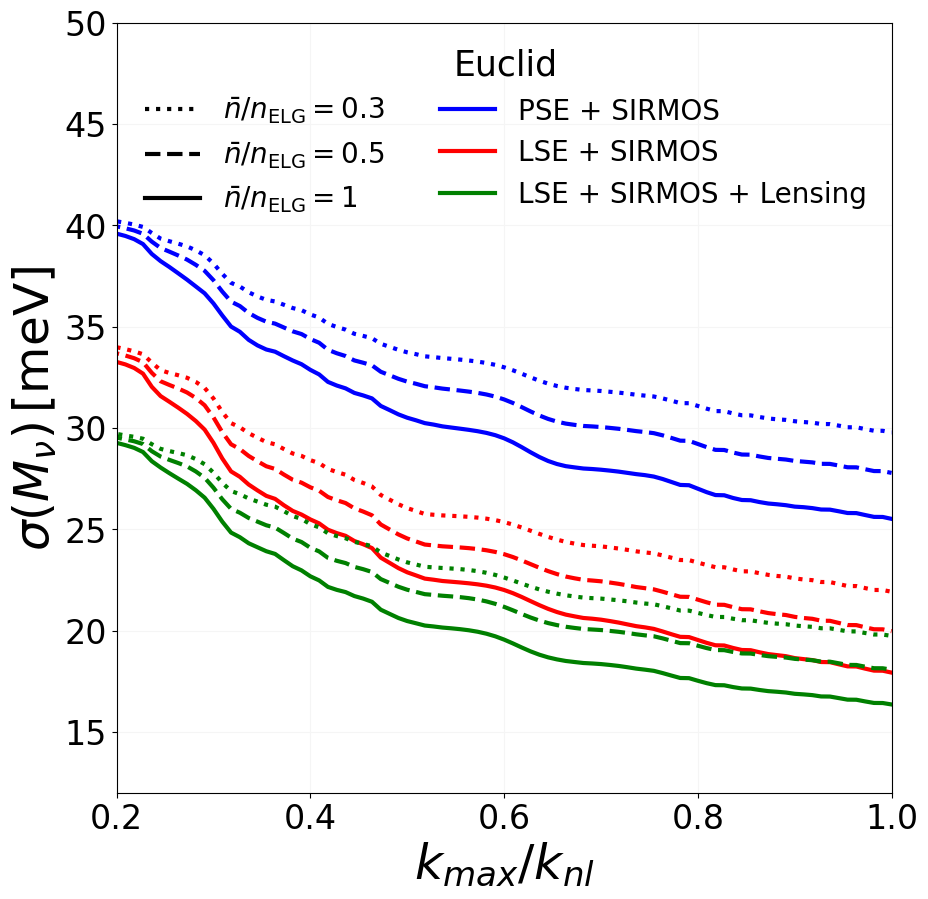

In [202]:
n_sirmos_2 = interp1d(z_tot_test, n_tot_sirmos_2)
n_sirmos_2_03 = interp1d(z_tot_test, (0.3) * n_tot_sirmos_2)
n_sirmos_2_05 = interp1d(z_tot_test, (0.5) * n_tot_sirmos_2)

SIRMOS_to_vary = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
SIRMOS_to_vary_03 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_03)
SIRMOS_to_vary_05 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_05)
euclid_to_vary = experiment(zmin = 0.9, zmax = 1.8, nbins = 4, Euclid = True, fsky = 0.36)

sirmosCast_to_vary = fisherForecast(experiment = SIRMOS_to_vary, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
sirmosCast_to_vary_03 = fisherForecast(experiment = SIRMOS_to_vary_03, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_03')
sirmosCast_to_vary_05 = fisherForecast(experiment = SIRMOS_to_vary_05, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_05')
euclidCast_to_vary = fisherForecast(experiment = euclid_to_vary, cosmo = cosmo, velocileptors=True,name='euclid_fiducial', basedir='data_test_msc/m_nu_plot/euclid')

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

sirmosCast_to_vary.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_03.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_05.free_params = basis_Pkmu_to_vary

sirmosCast_to_vary.compute_derivatives()
sirmosCast_to_vary_03.compute_derivatives()
sirmosCast_to_vary_05.compute_derivatives()

derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.load_derivatives(basis_Pkmu_to_vary)

euclidCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_euclid_m_nu_plot =  basis_Pkmu_to_vary
euclidCast_to_vary.compute_derivatives()
derivatives_Pkmu_euclid_m_nu_plot = euclidCast_to_vary.load_derivatives(basis_Pkmu_euclid_m_nu_plot)

basis_Cl_euclid_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'N','alpha0','alphax','b','b2','bs'])

euclidCast_to_vary.free_params = basis_Cl_euclid_to_vary
euclidCast_to_vary.compute_Cl_derivatives()

F_Pkmu_euclid_m_nu_plot = euclidCast_to_vary.gen_fisher(basis_Pkmu_euclid_m_nu_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_euclid_m_nu_plot) 
F_Cl_euclid_m_nu_plot = euclidCast_to_vary.gen_lensing_fisher(basis_Cl_euclid_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

indices_m_nu_plot = [0,1,2,3,4,5,6]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_m_nu_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_m_nu_plot = np.asmatrix(F_Planck_SO_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_m_nu_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_m_nu_plot = np.asmatrix(F_LiteBIRD_S4_new_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

m_nu_values_pse = []
m_nu_values_pse_03 = []
m_nu_values_pse_05 = []
m_nu_values_lse = []
m_nu_values_lse_03 = []
m_nu_values_lse_05 = []
m_nu_values_lse_lens = []
m_nu_values_lse_03_lens = []
m_nu_values_lse_05_lens = []

for i in np.linspace(0.1, 1, 100):
    F_Pkmu_sirmos_to_vary = sirmosCast_to_vary.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary)
    F_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_03)
    F_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_05)
    
    F_Pkmu_sirmos_to_vary_pse = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_pse_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_pse_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lse = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lse_lens = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_03_lens = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_05_lens = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    
    m_nu_value_pse = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse)))[6] * 10**3
    m_nu_values_pse.append(m_nu_value_pse)
    
    m_nu_value_pse_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse_03)))[6] * 10**3
    m_nu_values_pse_03.append(m_nu_value_pse_03)
    
    m_nu_value_pse_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse_05)))[6] * 10**3
    m_nu_values_pse_05.append(m_nu_value_pse_05)
    
    m_nu_value_lse = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse)))[6] * 10**3
    m_nu_values_lse.append(m_nu_value_lse)
    
    m_nu_value_lse_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_03)))[6] * 10**3
    m_nu_values_lse_03.append(m_nu_value_lse_03)
    
    m_nu_value_lse_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_05)))[6] * 10**3
    m_nu_values_lse_05.append(m_nu_value_lse_05)

    m_nu_value_lse_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_lens)))[6] * 10**3
    m_nu_values_lse_lens.append(m_nu_value_lse_lens)
    
    m_nu_value_lse_03_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_03_lens)))[6] * 10**3
    m_nu_values_lse_03_lens.append(m_nu_value_lse_03_lens)
    
    m_nu_value_lse_05_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_05_lens)))[6] * 10**3
    m_nu_values_lse_05_lens.append(m_nu_value_lse_05_lens)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse, c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse_03, linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse_05, linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse, c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_03, linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_05, linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_lens, c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_03_lens, linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_05_lens, linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$\sigma(M_{\nu})\,\mathrm{[meV]}$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(12,50)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PSE + SIRMOS',
    'LSE + SIRMOS',
    'LSE + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=20, title = 'Euclid', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('m_mu_vary_with_k_max_k_nl_euclid.pdf', bbox_inches='tight')
plt.show()


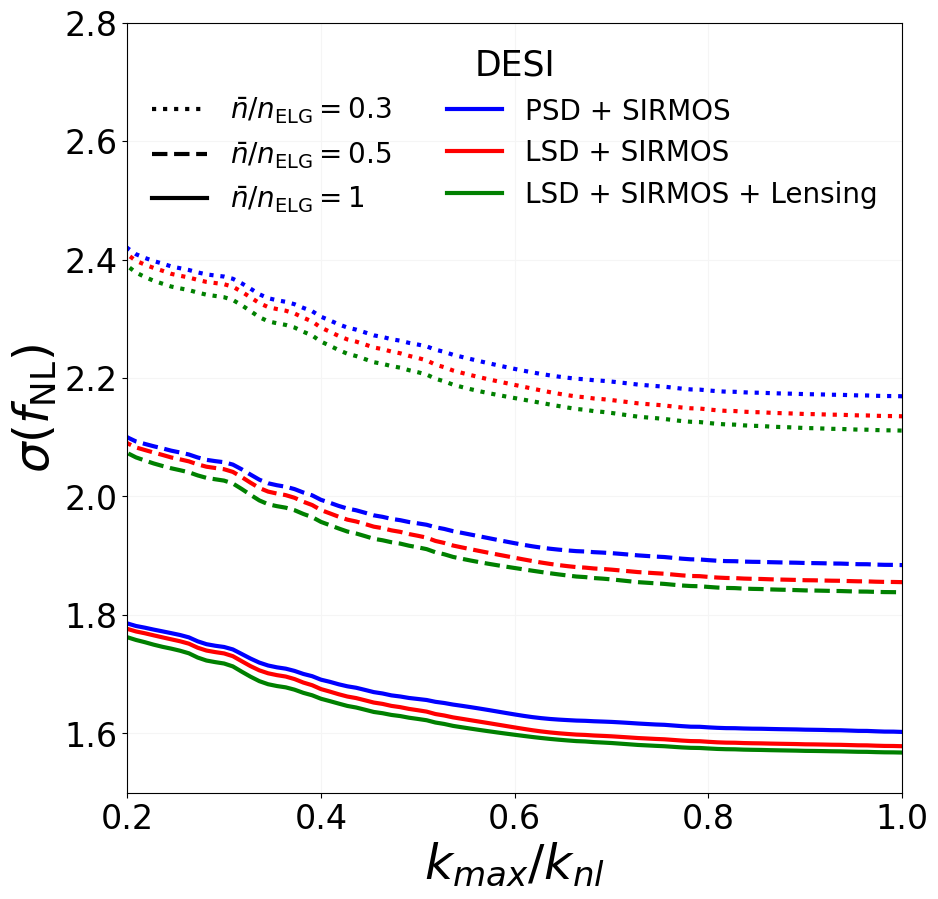

In [203]:
n_sirmos_2 = interp1d(z_tot_test, n_tot_sirmos_2)
n_sirmos_2_03 = interp1d(z_tot_test, (0.3) * n_tot_sirmos_2)
n_sirmos_2_05 = interp1d(z_tot_test, (0.5) * n_tot_sirmos_2)

SIRMOS_to_vary = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
SIRMOS_to_vary_03 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_03)
SIRMOS_to_vary_05 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_05)
DESI_to_vary = experiment(zmin = 0.6, zmax = 1.7, nbins = 4, ELG = True, fsky = 0.34)

sirmosCast_to_vary = fisherForecast(experiment = SIRMOS_to_vary, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
sirmosCast_to_vary_03 = fisherForecast(experiment = SIRMOS_to_vary_03, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_03')
sirmosCast_to_vary_05 = fisherForecast(experiment = SIRMOS_to_vary_05, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_05')
desiCast_to_vary = fisherForecast(experiment = DESI_to_vary, cosmo = cosmo, velocileptors=True,name='DESI_fiducial', basedir='data_test_msc/m_nu_plot/desi')

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

sirmosCast_to_vary.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_03.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_05.free_params = basis_Pkmu_to_vary

sirmosCast_to_vary.compute_derivatives()
sirmosCast_to_vary_03.compute_derivatives()
sirmosCast_to_vary_05.compute_derivatives()

derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.load_derivatives(basis_Pkmu_to_vary)

desiCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_desi_m_nu_plot =  basis_Pkmu_to_vary
desiCast_to_vary.compute_derivatives()
derivatives_Pkmu_desi_m_nu_plot = desiCast_to_vary.load_derivatives(basis_Pkmu_desi_m_nu_plot)

basis_Cl_desi_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'N','alpha0','alphax','b','b2','bs'])

desiCast_to_vary.free_params = basis_Cl_desi_to_vary
desiCast_to_vary.compute_Cl_derivatives()

F_Pkmu_desi_m_nu_plot = desiCast_to_vary.gen_fisher(basis_Pkmu_desi_m_nu_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_desi_m_nu_plot) 
F_Cl_desi_m_nu_plot = desiCast_to_vary.gen_lensing_fisher(basis_Cl_desi_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

indices_m_nu_plot = [0,1,2,3,4,5,10]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_m_nu_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_m_nu_plot = np.asmatrix(F_Planck_SO_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_m_nu_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_m_nu_plot = np.asmatrix(F_LiteBIRD_S4_new_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

m_nu_values_psd_f_nl = []
m_nu_values_psd_f_nl_03 = []
m_nu_values_psd_f_nl_05 = []
m_nu_values_lsd_f_nl = []
m_nu_values_lsd_f_nl_03 = []
m_nu_values_lsd_f_nl_05 = []
m_nu_values_lsd_f_nl_lens = []
m_nu_values_lsd_f_nl_03_lens = []
m_nu_values_lsd_f_nl_05_lens = []

for i in np.linspace(0.1, 1, 100):
    F_Pkmu_sirmos_to_vary = sirmosCast_to_vary.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary)
    F_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_03)
    F_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_05)
    
    F_Pkmu_sirmos_to_vary_psd_f_nl = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_psd_f_nl_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_psd_f_nl_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lsd_f_nl = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_f_nl_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_f_nl_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lsd_f_nl_lens = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_f_nl_03_lens = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_f_nl_05_lens = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    
    m_nu_value_psd_f_nl = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_f_nl)))[6] 
    m_nu_values_psd_f_nl.append(m_nu_value_psd_f_nl)
    
    m_nu_value_psd_f_nl_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_f_nl_03)))[6] 
    m_nu_values_psd_f_nl_03.append(m_nu_value_psd_f_nl_03)
    
    m_nu_value_psd_f_nl_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_f_nl_05)))[6] 
    m_nu_values_psd_f_nl_05.append(m_nu_value_psd_f_nl_05)
    
    m_nu_value_lsd_f_nl = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl)))[6] 
    m_nu_values_lsd_f_nl.append(m_nu_value_lsd_f_nl)
    
    m_nu_value_lsd_f_nl_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl_03)))[6] 
    m_nu_values_lsd_f_nl_03.append(m_nu_value_lsd_f_nl_03)
    
    m_nu_value_lsd_f_nl_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl_05)))[6] 
    m_nu_values_lsd_f_nl_05.append(m_nu_value_lsd_f_nl_05)

    m_nu_value_lsd_f_nl_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl_lens)))[6] 
    m_nu_values_lsd_f_nl_lens.append(m_nu_value_lsd_f_nl_lens)
    
    m_nu_value_lsd_f_nl_03_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl_03_lens)))[6] 
    m_nu_values_lsd_f_nl_03_lens.append(m_nu_value_lsd_f_nl_03_lens)
    
    m_nu_value_lsd_f_nl_05_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_f_nl_05_lens)))[6] 
    m_nu_values_lsd_f_nl_05_lens.append(m_nu_value_lsd_f_nl_05_lens)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd_f_nl, c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd_f_nl_03, linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_psd_f_nl_05, linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl, c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl_03, linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl_05, linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl_lens, c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl_03_lens, linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lsd_f_nl_05_lens, linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$σ(f_{\mathrm{NL}})$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(1.5,2.8)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PSD + SIRMOS',
    'LSD + SIRMOS',
    'LSD + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=20, title = 'DESI', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('f_nl_vary_with_k_max_k_nl_desi.pdf', bbox_inches='tight')
plt.show()


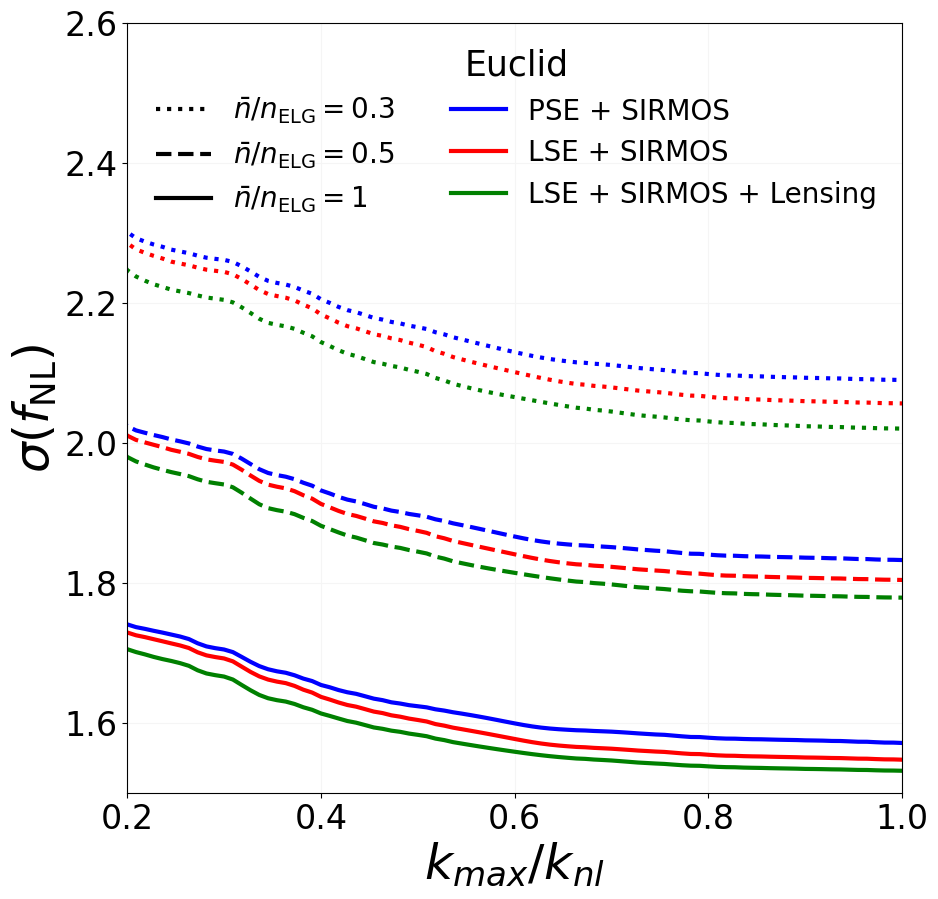

In [204]:
n_sirmos_2 = interp1d(z_tot_test, n_tot_sirmos_2)
n_sirmos_2_03 = interp1d(z_tot_test, (0.3) * n_tot_sirmos_2)
n_sirmos_2_05 = interp1d(z_tot_test, (0.5) * n_tot_sirmos_2)

SIRMOS_to_vary = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
SIRMOS_to_vary_03 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_03)
SIRMOS_to_vary_05 = experiment(zmin = 1., zmax = 4., nbins = 4, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2_05)
euclid_to_vary = experiment(zmin = 0.9, zmax = 1.8, nbins = 4, Euclid = True, fsky = 0.36)

sirmosCast_to_vary = fisherForecast(experiment = SIRMOS_to_vary, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
sirmosCast_to_vary_03 = fisherForecast(experiment = SIRMOS_to_vary_03, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_03')
sirmosCast_to_vary_05 = fisherForecast(experiment = SIRMOS_to_vary_05, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_05')
euclidCast_to_vary = fisherForecast(experiment = euclid_to_vary, cosmo = cosmo, velocileptors=True,name='euclid_fiducial', basedir='data_test_msc/m_nu_plot/euclid')

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

sirmosCast_to_vary.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_03.free_params = basis_Pkmu_to_vary
sirmosCast_to_vary_05.free_params = basis_Pkmu_to_vary

sirmosCast_to_vary.compute_derivatives()
sirmosCast_to_vary_03.compute_derivatives()
sirmosCast_to_vary_05.compute_derivatives()

derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.load_derivatives(basis_Pkmu_to_vary)
derivatives_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.load_derivatives(basis_Pkmu_to_vary)

euclidCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_euclid_m_nu_plot =  basis_Pkmu_to_vary
euclidCast_to_vary.compute_derivatives()
derivatives_Pkmu_euclid_m_nu_plot = euclidCast_to_vary.load_derivatives(basis_Pkmu_euclid_m_nu_plot)

basis_Cl_euclid_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'N','alpha0','alphax','b','b2','bs'])

euclidCast_to_vary.free_params = basis_Cl_euclid_to_vary
euclidCast_to_vary.compute_Cl_derivatives()

F_Pkmu_euclid_m_nu_plot = euclidCast_to_vary.gen_fisher(basis_Pkmu_euclid_m_nu_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_euclid_m_nu_plot) 
F_Cl_euclid_m_nu_plot = euclidCast_to_vary.gen_lensing_fisher(basis_Cl_euclid_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

indices_m_nu_plot = [0,1,2,3,4,5,10]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_m_nu_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_m_nu_plot = np.asmatrix(F_Planck_SO_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_m_nu_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_m_nu_plot = np.asmatrix(F_LiteBIRD_S4_new_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

m_nu_values_pse_f_nl = []
m_nu_values_pse_f_nl_03 = []
m_nu_values_pse_f_nl_05 = []
m_nu_values_lse_f_nl = []
m_nu_values_lse_f_nl_03 = []
m_nu_values_lse_f_nl_05 = []
m_nu_values_lse_f_nl_lens = []
m_nu_values_lse_f_nl_03_lens = []
m_nu_values_lse_f_nl_05_lens = []

for i in np.linspace(0.1, 1, 100):
    F_Pkmu_sirmos_to_vary = sirmosCast_to_vary.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary)
    F_Pkmu_sirmos_to_vary_03 = sirmosCast_to_vary_03.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_03)
    F_Pkmu_sirmos_to_vary_05 = sirmosCast_to_vary_05.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=i, derivatives=derivatives_Pkmu_sirmos_to_vary_05)
    
    F_Pkmu_sirmos_to_vary_pse_f_nl = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_pse_f_nl_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_pse_f_nl_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_Planck_SO_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lse_f_nl = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_f_nl_03 = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_f_nl_05 = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot],7)
    
    F_Pkmu_sirmos_to_vary_lse_f_nl_lens = sirmosCast_to_vary.combine_fishers([F_Pkmu_sirmos_to_vary, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_f_nl_03_lens = sirmosCast_to_vary_03.combine_fishers([F_Pkmu_sirmos_to_vary_03, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lse_f_nl_05_lens = sirmosCast_to_vary_05.combine_fishers([F_Pkmu_sirmos_to_vary_05, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_euclid_m_nu_plot, F_Cl_euclid_m_nu_plot],7)
    
    m_nu_value_pse_f_nl = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse_f_nl)))[6] 
    m_nu_values_pse_f_nl.append(m_nu_value_pse_f_nl)
    
    m_nu_value_pse_f_nl_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse_f_nl_03)))[6] 
    m_nu_values_pse_f_nl_03.append(m_nu_value_pse_f_nl_03)
    
    m_nu_value_pse_f_nl_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_pse_f_nl_05)))[6] 
    m_nu_values_pse_f_nl_05.append(m_nu_value_pse_f_nl_05)
    
    m_nu_value_lse_f_nl = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl)))[6] 
    m_nu_values_lse_f_nl.append(m_nu_value_lse_f_nl)
    
    m_nu_value_lse_f_nl_03 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl_03)))[6] 
    m_nu_values_lse_f_nl_03.append(m_nu_value_lse_f_nl_03)
    
    m_nu_value_lse_f_nl_05 = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl_05)))[6] 
    m_nu_values_lse_f_nl_05.append(m_nu_value_lse_f_nl_05)

    m_nu_value_lse_f_nl_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl_lens)))[6] 
    m_nu_values_lse_f_nl_lens.append(m_nu_value_lse_f_nl_lens)
    
    m_nu_value_lse_f_nl_03_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl_03_lens)))[6] 
    m_nu_values_lse_f_nl_03_lens.append(m_nu_value_lse_f_nl_03_lens)
    
    m_nu_value_lse_f_nl_05_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lse_f_nl_05_lens)))[6] 
    m_nu_values_lse_f_nl_05_lens.append(m_nu_value_lse_f_nl_05_lens)

plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse_f_nl, c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse_f_nl_03, linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_pse_f_nl_05, linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl, c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl_03, linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl_05, linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl_lens, c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl_03_lens, linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), m_nu_values_lse_f_nl_05_lens, linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$\sigma(f_{\mathrm{NL}})$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(1.5,2.6)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PSE + SIRMOS',
    'LSE + SIRMOS',
    'LSE + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=20, title = 'Euclid', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('f_nl_vary_with_k_max_k_nl_euclid.pdf', bbox_inches='tight')
plt.show()


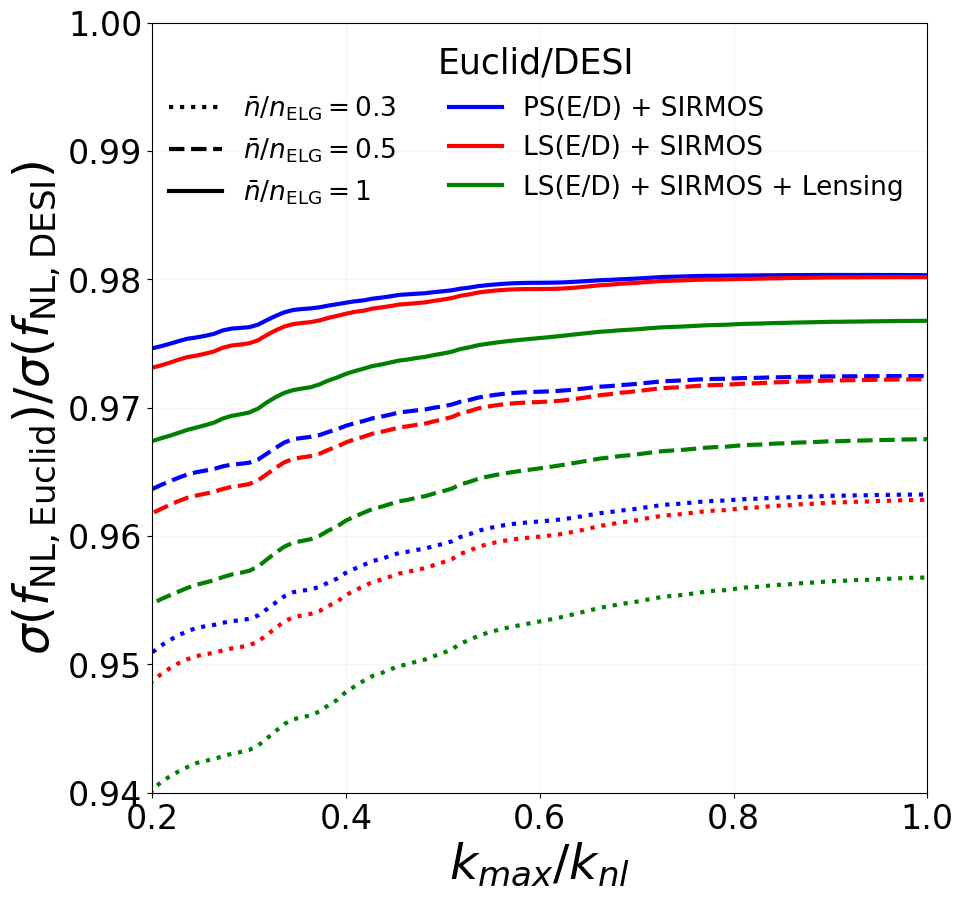

In [205]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse_f_nl)/np.array(m_nu_values_psd_f_nl), c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse_f_nl_03)/np.array(m_nu_values_psd_f_nl_03), linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse_f_nl_05)/np.array(m_nu_values_psd_f_nl_05), linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl)/np.array(m_nu_values_lsd_f_nl), c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl_03)/np.array(m_nu_values_lsd_f_nl_03), linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl_05)/np.array(m_nu_values_lsd_f_nl_05), linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl_lens)/np.array(m_nu_values_lsd_f_nl_lens), c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl_03_lens)/np.array(m_nu_values_lsd_f_nl_03_lens), linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_f_nl_05_lens)/np.array(m_nu_values_lsd_f_nl_05_lens), linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$\sigma(f_{\mathrm{NL, Euclid}})/\sigma(f_{\mathrm{NL, DESI}})$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(0.94,1)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PS(E/D) + SIRMOS',
    'LS(E/D) + SIRMOS',
    'LS(E/D) + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=19, title = 'Euclid/DESI', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('f_nl_vary_with_k_max_k_nl_euclid_over_desi.pdf', bbox_inches='tight')
plt.show()

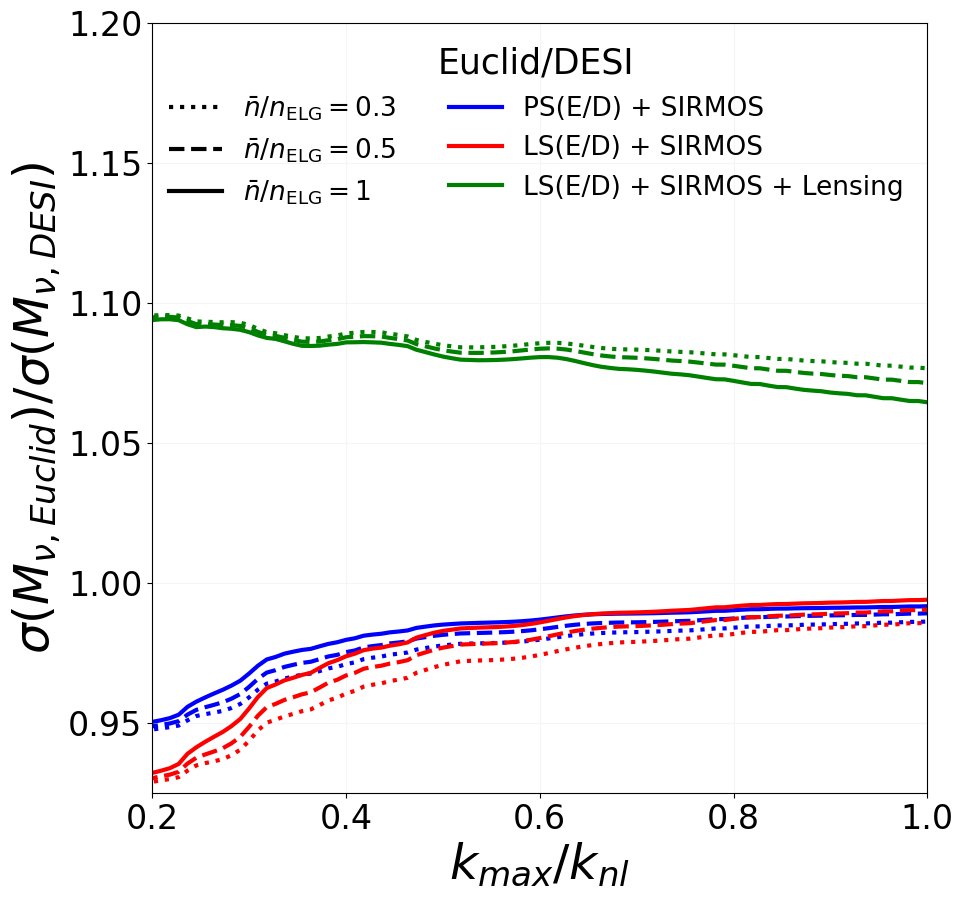

In [206]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse)/np.array(m_nu_values_psd), c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse_03)/np.array(m_nu_values_psd_03), linestyle = ':', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_pse_05)/np.array(m_nu_values_psd_05), linestyle = '--', c = 'b', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse)/np.array(m_nu_values_lsd), c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_03)/np.array(m_nu_values_lsd_03), linestyle = ':', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_05)/np.array(m_nu_values_lsd_05), linestyle = '--', c = 'r', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_lens)/np.array(m_nu_values_lsd_lens), c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_03_lens)/np.array(m_nu_values_lsd_03_lens), linestyle = ':', c = 'g', linewidth = 3)
plt.plot(np.linspace(0.1, 1, 100), np.array(m_nu_values_lse_05_lens)/np.array(m_nu_values_lsd_05_lens), linestyle = '--', c = 'g', linewidth = 3)
plt.xlabel(r'$k_{max}/k_{nl}$', fontsize = 35)
plt.ylabel(r'$\sigma(M_{ν, Euclid})/\sigma(M_{ν, DESI})$', fontsize = 35)
plt.xlim(0.2,1)
plt.ylim(0.925,1.2)
plt.grid(c='whitesmoke')
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle=':'),
    Line2D([0], [0], color='black', lw=3, linestyle='--'),
    Line2D([0], [0], color='black', lw=3),
    Line2D([0], [0], color='b', lw=3),
    Line2D([0], [0], color='r', lw=3),
    Line2D([0], [0], color='g', lw=3)]

legend_labels = [
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.3$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 0.5$',
    r'$\bar{n}/n_{\mathrm{ELG}} = 1$',
    'PS(E/D) + SIRMOS',
    'LS(E/D) + SIRMOS',
    'LS(E/D) + SIRMOS + Lensing']

plt.legend(custom_lines, legend_labels, frameon=False, fontsize=19, title = 'Euclid/DESI', title_fontsize = 25, ncol = 2)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.savefig('m_nu_vary_with_k_max_k_nl_euclid_over_desi.pdf', bbox_inches='tight')
plt.show()

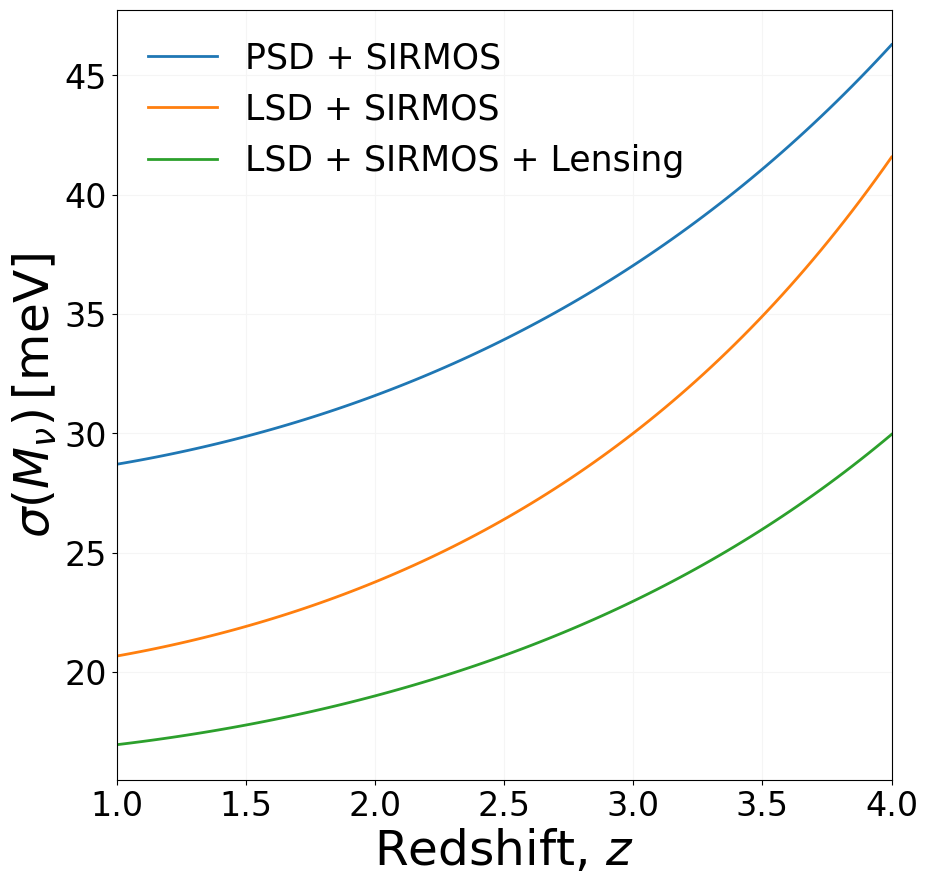

In [207]:
zmin_values = [1.0, 1.75, 2.5, 3.25]
zmax_values = [1.75, 2.5, 3.25, 4]
z_center_values = [1.375, 2.125, 2.875, 3.625]

indices_m_nu_plot = [0,1,2,3,4,5,6]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_m_nu_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_m_nu_plot = np.asmatrix(F_Planck_SO_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_m_nu_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_m_nu_plot = np.asmatrix(F_LiteBIRD_S4_new_m_nu_plot[np.ix_(indices_m_nu_plot, indices_m_nu_plot)])

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

basis_Cl_desi_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'm_ncdm',\
                             'N','alpha0','alphax','b','b2','bs'])

DESI_to_vary = experiment(zmin = 0.6, zmax = 1.7, nbins = 4, ELG = True, fsky = 0.34)
desiCast_to_vary = fisherForecast(experiment = DESI_to_vary, cosmo = cosmo, velocileptors=True,name='DESI_fiducial', basedir='data_test_msc/m_nu_plot/desi')

desiCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_desi_m_nu_plot =  basis_Pkmu_to_vary
desiCast_to_vary.compute_derivatives()
derivatives_Pkmu_desi_m_nu_plot = desiCast_to_vary.load_derivatives(basis_Pkmu_desi_m_nu_plot)

desiCast_to_vary.free_params = basis_Cl_desi_to_vary
desiCast_to_vary.compute_Cl_derivatives()

F_Pkmu_desi_m_nu_plot = desiCast_to_vary.gen_fisher(basis_Pkmu_desi_m_nu_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_desi_m_nu_plot) 
F_Cl_desi_m_nu_plot = desiCast_to_vary.gen_lensing_fisher(basis_Cl_desi_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

m_nu_values_psd_redshift = []
m_nu_values_lsd_redshift = []
m_nu_values_lsd_redshift_lens = []

for i in range(4):
    SIRMOS_to_vary_redshift = experiment(zmin = zmin_values[i], zmax = zmax_values[i], nbins = 1, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
    sirmosCast_to_vary_redshift = fisherForecast(experiment = SIRMOS_to_vary_redshift, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
    sirmosCast_to_vary_redshift.free_params = basis_Pkmu_to_vary
    sirmosCast_to_vary_redshift.compute_derivatives()
    derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary_redshift.load_derivatives(basis_Pkmu_to_vary)

    F_Pkmu_sirmos_to_vary_redshift = sirmosCast_to_vary_redshift.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=1, derivatives=derivatives_Pkmu_sirmos_to_vary)
    
    F_Pkmu_sirmos_to_vary_psd_redshift = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_Planck_SO_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_redshift = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_redshift_lens = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_LiteBIRD_S4_new_m_nu_plot, F_Pkmu_desi_m_nu_plot, F_Cl_desi_m_nu_plot],7)
    
    m_nu_value_psd_redshift = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_redshift)))[6] *10**3
    m_nu_values_psd_redshift.append(m_nu_value_psd_redshift)
    
    m_nu_value_lsd_redshift = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_redshift)))[6] *10**3
    m_nu_values_lsd_redshift.append(m_nu_value_lsd_redshift)
    
    m_nu_value_lsd_redshift_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_redshift_lens)))[6] *10**3
    m_nu_values_lsd_redshift_lens.append(m_nu_value_lsd_redshift_lens)

def exp_func(x, A, B):
    y = A * np.exp(B * x**2)
    return y

z_values_plot = np.linspace(1,4,100)

params_psd, cov_psd = curve_fit(exp_func, z_center_values, m_nu_values_psd_redshift)
params_lsd, cov_lsd = curve_fit(exp_func, z_center_values, m_nu_values_lsd_redshift)
params_lsd_lens, cov_lsd_lens = curve_fit(exp_func, z_center_values, m_nu_values_lsd_redshift_lens)

m_nu_values_psd_redshift_fig = exp_func(z_values_plot, params_psd[0], params_psd[1])
m_nu_values_lsd_redshift_fig = exp_func(z_values_plot, params_lsd[0], params_lsd[1])
m_nu_values_lsd_lens_redshift_fig = exp_func(z_values_plot, params_lsd_lens[0], params_lsd_lens[1])

plt.figure(figsize=(10, 10))
plt.plot(z_values_plot, m_nu_values_psd_redshift_fig, linewidth=2, label='PSD + SIRMOS')
plt.plot(z_values_plot, m_nu_values_lsd_redshift_fig, linewidth=2, label='LSD + SIRMOS')
plt.plot(z_values_plot, m_nu_values_lsd_lens_redshift_fig, linewidth=2, label='LSD + SIRMOS + Lensing')
plt.grid(c='whitesmoke')
plt.xlim(1,4)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.xlabel(r'Redshift, $z$', fontsize=35)
plt.ylabel(r'$\sigma(M_{\nu})\,\mathrm{[meV]}$', fontsize=35)
plt.legend(frameon = False, fontsize=25)
plt.savefig('m_nu_constraint_against_redshift.pdf')
plt.show()

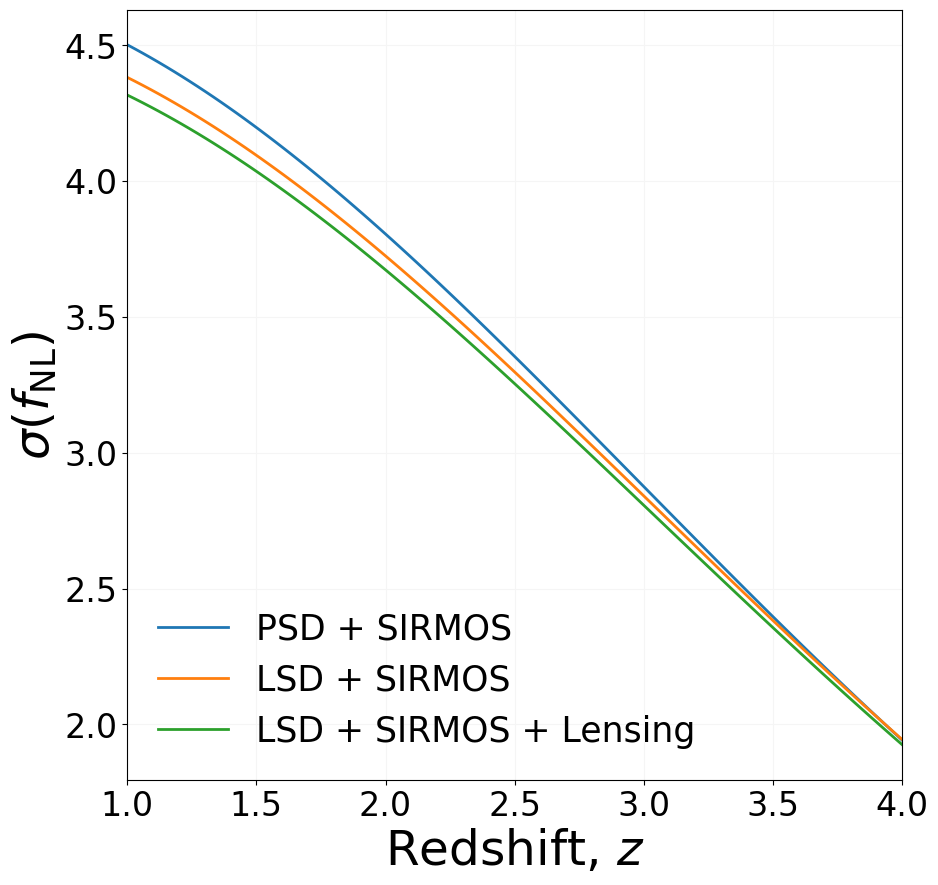

In [208]:
zmin_values = [1.0, 1.75, 2.5, 3.25]
zmax_values = [1.75, 2.5, 3.25, 4]
z_center_values = [1.375, 2.125, 2.875, 3.625]

indices_f_nl_plot = [0,1,2,3,4,5,10]

F_Planck_SO = np.genfromtxt('input/Planck_SO.txt')
F_Planck_SO_f_nl_plot = F_Planck_SO.reshape(11,11)
F_Planck_SO_new_f_nl_plot = np.asmatrix(F_Planck_SO_f_nl_plot[np.ix_(indices_f_nl_plot, indices_f_nl_plot)])

F_LiteBIRD_S4 = np.genfromtxt('input/LiteBIRD_S4.txt')
F_LiteBIRD_S4_new_f_nl_plot = F_LiteBIRD_S4.reshape(11,11)
F_LiteBIRD_S4_new_f_nl_plot = np.asmatrix(F_LiteBIRD_S4_new_f_nl_plot[np.ix_(indices_f_nl_plot, indices_f_nl_plot)])

basis_Pkmu_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'b','b2','bs','N','N2','N4','alpha0','alpha2','alpha4'])

basis_Cl_desi_to_vary = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio', 'f_NL',\
                             'N','alpha0','alphax','b','b2','bs'])

DESI_to_vary = experiment(zmin = 0.6, zmax = 1.7, nbins = 4, ELG = True, fsky = 0.34)
desiCast_to_vary = fisherForecast(experiment = DESI_to_vary, cosmo = cosmo, velocileptors=True,name='DESI_fiducial', basedir='data_test_msc/m_nu_plot/desi')

desiCast_to_vary.free_params = basis_Pkmu_to_vary
basis_Pkmu_desi_f_nl_plot =  basis_Pkmu_to_vary
desiCast_to_vary.compute_derivatives()
derivatives_Pkmu_desi_f_nl_plot = desiCast_to_vary.load_derivatives(basis_Pkmu_desi_f_nl_plot)

desiCast_to_vary.free_params = basis_Cl_desi_to_vary
desiCast_to_vary.compute_Cl_derivatives()

F_Pkmu_desi_f_nl_plot = desiCast_to_vary.gen_fisher(basis_Pkmu_desi_f_nl_plot,7,kmax_knl=1,derivatives=derivatives_Pkmu_desi_f_nl_plot) 
F_Cl_desi_f_nl_plot = desiCast_to_vary.gen_lensing_fisher(basis_Cl_desi_to_vary,7,ell_min=30,ell_max=500,kmax_knl=1,CMB='S4')

f_nl_values_psd_redshift = []
f_nl_values_lsd_redshift = []
f_nl_values_lsd_redshift_lens = []

for i in range(4):
    SIRMOS_to_vary_redshift = experiment(zmin = zmin_values[i], zmax = zmax_values[i], nbins = 1, fsky = 15000/41252.96125, custom_n = True, ELG = True, n = n_sirmos_2)
    sirmosCast_to_vary_redshift = fisherForecast(experiment = SIRMOS_to_vary_redshift, cosmo = cosmo, velocileptors=True,name='SIRMOS_fiducial', basedir='data_test_msc/m_nu_plot/sirmos_n_1')
    sirmosCast_to_vary_redshift.free_params = basis_Pkmu_to_vary
    sirmosCast_to_vary_redshift.compute_derivatives()
    derivatives_Pkmu_sirmos_to_vary = sirmosCast_to_vary_redshift.load_derivatives(basis_Pkmu_to_vary)

    F_Pkmu_sirmos_to_vary_redshift = sirmosCast_to_vary_redshift.gen_fisher(basis_Pkmu_to_vary, 7, kmax_knl=1, derivatives=derivatives_Pkmu_sirmos_to_vary)
    
    F_Pkmu_sirmos_to_vary_psd_redshift = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_Planck_SO_new_f_nl_plot, F_Pkmu_desi_f_nl_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_redshift = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_LiteBIRD_S4_new_f_nl_plot, F_Pkmu_desi_f_nl_plot],7)
    F_Pkmu_sirmos_to_vary_lsd_redshift_lens = sirmosCast_to_vary_redshift.combine_fishers([F_Pkmu_sirmos_to_vary_redshift, F_LiteBIRD_S4_new_f_nl_plot, F_Pkmu_desi_f_nl_plot, F_Cl_desi_f_nl_plot],7)
    
    f_nl_value_psd_redshift = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_psd_redshift)))[6] 
    f_nl_values_psd_redshift.append(f_nl_value_psd_redshift)
    
    f_nl_value_lsd_redshift = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_redshift)))[6] 
    f_nl_values_lsd_redshift.append(f_nl_value_lsd_redshift)
    
    f_nl_value_lsd_redshift_lens = np.sqrt(np.diag(np.linalg.inv(F_Pkmu_sirmos_to_vary_lsd_redshift_lens)))[6] 
    f_nl_values_lsd_redshift_lens.append(f_nl_value_lsd_redshift_lens)

def exp_func(x, A, B):
    y = A * np.exp(B * x**2)
    return y

z_values_plot = np.linspace(1,4,100)

params_psd, cov_psd = curve_fit(exp_func, z_center_values, f_nl_values_psd_redshift)
params_lsd, cov_lsd = curve_fit(exp_func, z_center_values, f_nl_values_lsd_redshift)
params_lsd_lens, cov_lsd_lens = curve_fit(exp_func, z_center_values, f_nl_values_lsd_redshift_lens)

f_nl_values_psd_redshift_fig = exp_func(z_values_plot, params_psd[0], params_psd[1])
f_nl_values_lsd_redshift_fig = exp_func(z_values_plot, params_lsd[0], params_lsd[1])
f_nl_values_lsd_lens_redshift_fig = exp_func(z_values_plot, params_lsd_lens[0], params_lsd_lens[1])

plt.figure(figsize=(10, 10))
plt.plot(z_values_plot, f_nl_values_psd_redshift_fig, linewidth=2, label='PSD + SIRMOS')
plt.plot(z_values_plot, f_nl_values_lsd_redshift_fig, linewidth=2, label='LSD + SIRMOS')
plt.plot(z_values_plot, f_nl_values_lsd_lens_redshift_fig, linewidth=2, label='LSD + SIRMOS + Lensing')
plt.grid(c='whitesmoke')
plt.xlim(1,4)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.xlabel(r'Redshift, $z$', fontsize=35)
plt.ylabel(r'$\sigma(f_{\mathrm{NL}})$', fontsize=35)
plt.legend(frameon = False, fontsize=25)
plt.savefig('f_nl_constraint_against_redshift.pdf')
plt.show()

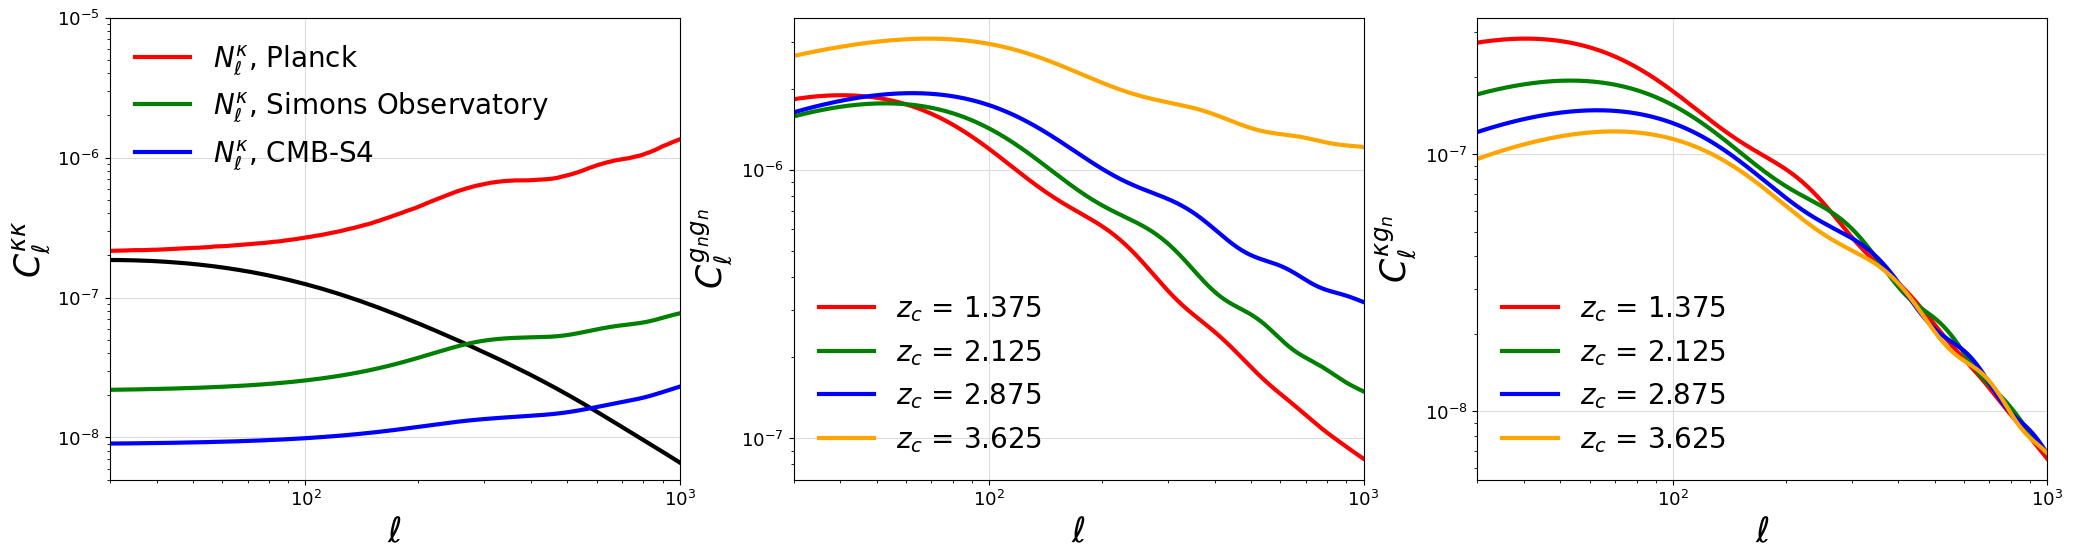

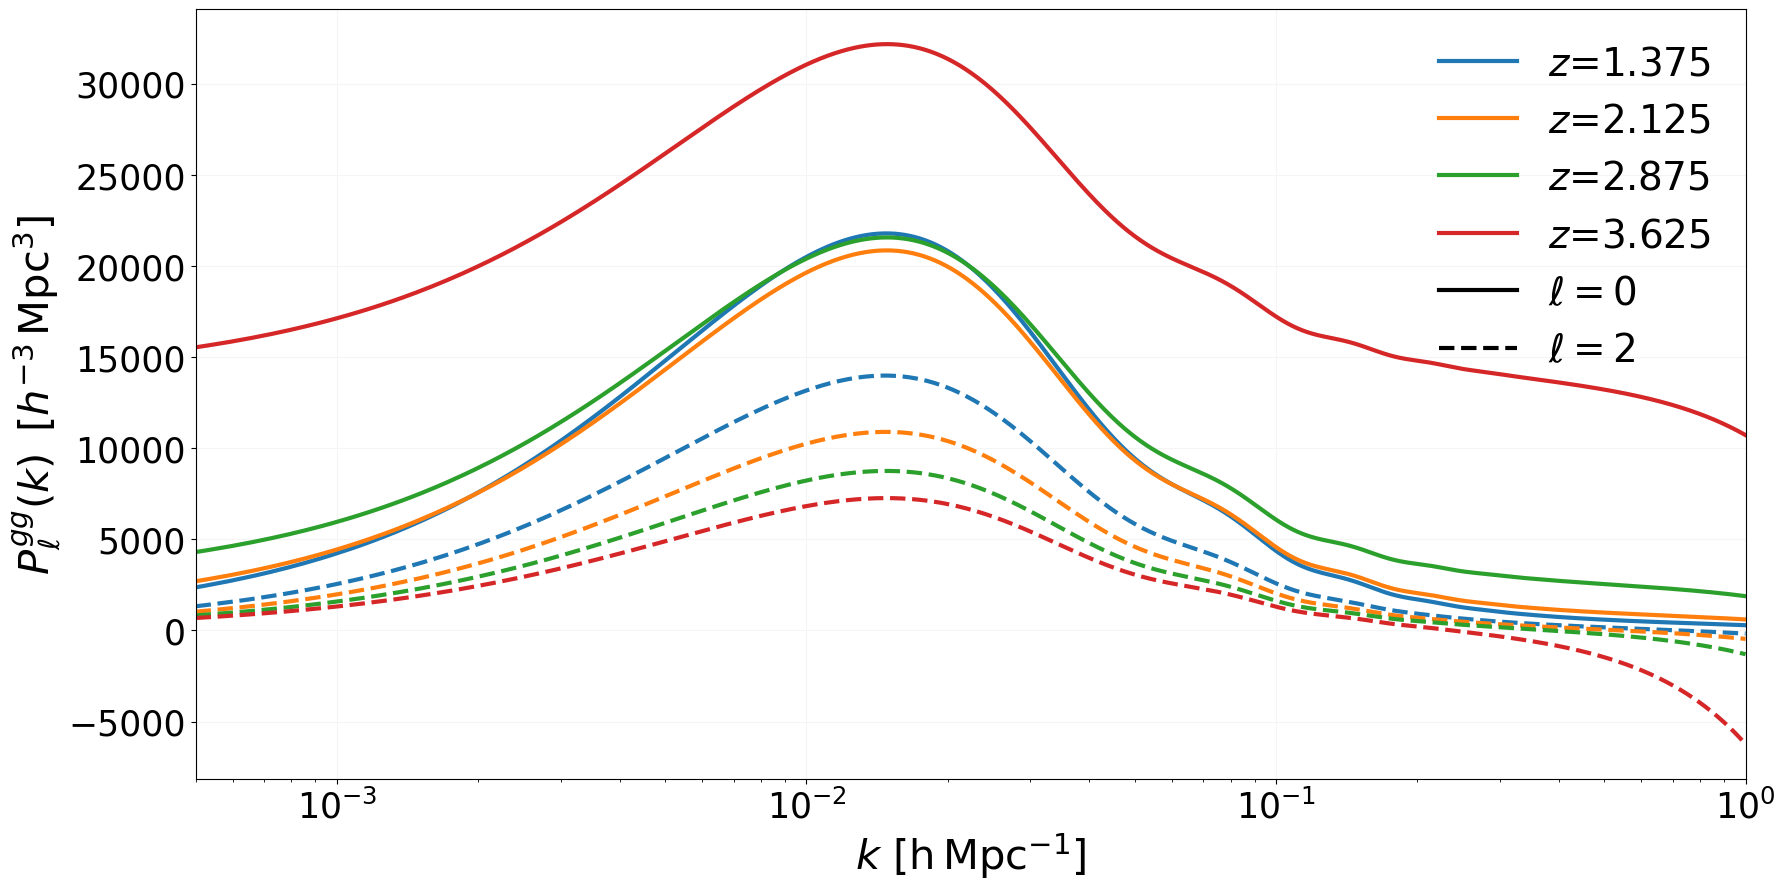

In [209]:
file_path_SO = 'input/nlkk_v3_1_0deproj0_SENS2_fsky0p4_it_lT30-3000_lP30-5000.dat'
df_SO = pd.read_csv(file_path_SO, delimiter='\t', header=None)

selected_values_SO = df_SO.iloc[28:1018, 0].str.split().apply(lambda x: [float(val) for val in x])

file_path_Planck = 'input/nlkk_planck.dat'
df_Planck = pd.read_csv(file_path_Planck, delimiter='\t', header=None)

selected_values_Planck = df_Planck.iloc[28:1018, 0].str.split().apply(lambda x: [float(val) for val in x])

file_path_s4 = 'input/S4_kappa_deproj0_sens0_16000_lT30-3000_lP30-5000.dat'
df_s4 = pd.read_csv(file_path_s4, delimiter='\t', header=None)

selected_values_s4 = df_s4.iloc[28:1018, 0].str.split().apply(lambda x: [float(val) for val in x])

N_kappa_SO = [row[7] for row in selected_values_SO]
N_kappa_Planck = [row[1] for row in selected_values_Planck]
N_kappa_s4 = [row[7] for row in selected_values_s4]

fig, ax = plt.subplots(1,3, figsize = (25, 6))
k = sirmosCast_2.k.reshape((sirmosCast_2.Nk,sirmosCast_2.Nmu))[:,0]
l = sirmosCast_2.ell

colours = ['red', 'green', 'blue', 'orange']

ax[0].loglog(l,sirmosCast_2.Ckk_fid,c='black',linewidth=3)
ax[0].loglog(l, N_kappa_Planck, color='red', label='$N_{\ell}^{\kappa}$, Planck', linewidth = 3)
ax[0].loglog(l, N_kappa_SO, color='green', label='$N_{\ell}^{\kappa}$, Simons Observatory', linewidth = 3)
ax[0].loglog(l, N_kappa_s4, color='blue', label='$N_{\ell}^{\kappa}$, CMB-S4', linewidth = 3)
ax[0].set_xlim(30, 1000)
ax[0].grid(c='gainsboro')
ax[0].legend(frameon = False, fontsize = 20)
ax[0].set_xlabel('$\ell$', fontsize = 25)
ax[0].set_ylabel('$C_{\ell}^{\kappa \kappa}$', fontsize = 25)
ax[0].set_ylim(5*10**(-9), 10**(-5))
ax[0].tick_params(axis='both', which='major', labelsize=13)

for i in range(4): 
    z = SIRMOS_2.zcenters[i]
    ax[1].loglog(l,sirmosCast_2.Cgg_fid[i],c=colours[i],linewidth=3, label = f'$z_c$ = {z}')
    ax[1].set_xlim(30, 1000)
ax[1].grid(c='gainsboro')
ax[1].set_xlabel('$\ell$', fontsize = 25)
ax[1].set_ylabel('$C_{\ell}^{g_n g_n}$', fontsize = 25)
ax[1].legend(frameon = False, fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize=13)

for i in range(4): 
    z = SIRMOS_2.zcenters[i]
    ax[2].loglog(l,sirmosCast_2.Ckg_fid[i],c=colours[i],linewidth=3, label = f'$z_c$ = {z}')
    ax[2].set_xlim(30, 1000)
ax[2].grid(c='gainsboro')
ax[2].legend(frameon = False, fontsize = 20)
ax[2].set_xlabel('$\ell$', fontsize = 25)
ax[2].set_ylabel('$C_{\ell}^{\kappa g_n}$', fontsize = 25)
ax[2].tick_params(axis='both', which='major', labelsize=13)
plt.savefig('lensing_ang_spec_all_3.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize = (20,10))
for i in range(4): 
    z = sirmosCast_2.experiment.zcenters[i]
    Pkmu = sirmosCast_2.P_fid[i]
    P0 = sirmosCast_2.LegendreTrans(0,Pkmu)
    P2 = sirmosCast_2.LegendreTrans(2,Pkmu)
    plt.semilogx(k,P0,c='C'+str(i),lw=3,label=r'$z$='+str(z))
    plt.semilogx(k,P2,c='C'+str(i),lw=3,ls='--')
plt.semilogx([],[],lw=3,c='k',label=r'$\ell=0$')
plt.semilogx([],[],lw=3,c='k',ls='--',label=r'$\ell=2$')
plt.xlim(min(k), max(k))
plt.legend(frameon = False, fontsize = 28)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('$k \,\,[\mathrm{h \, Mpc^{-1}}]$', fontsize = 30)
plt.ylabel(r'$P^{gg}_\ell(k)\,\,\,[h^{-3}\,\text{Mpc}^{3}]$', fontsize = 30)
plt.grid(c='whitesmoke')
plt.savefig('matter_power_spec_sirmos.pdf')
plt.show()

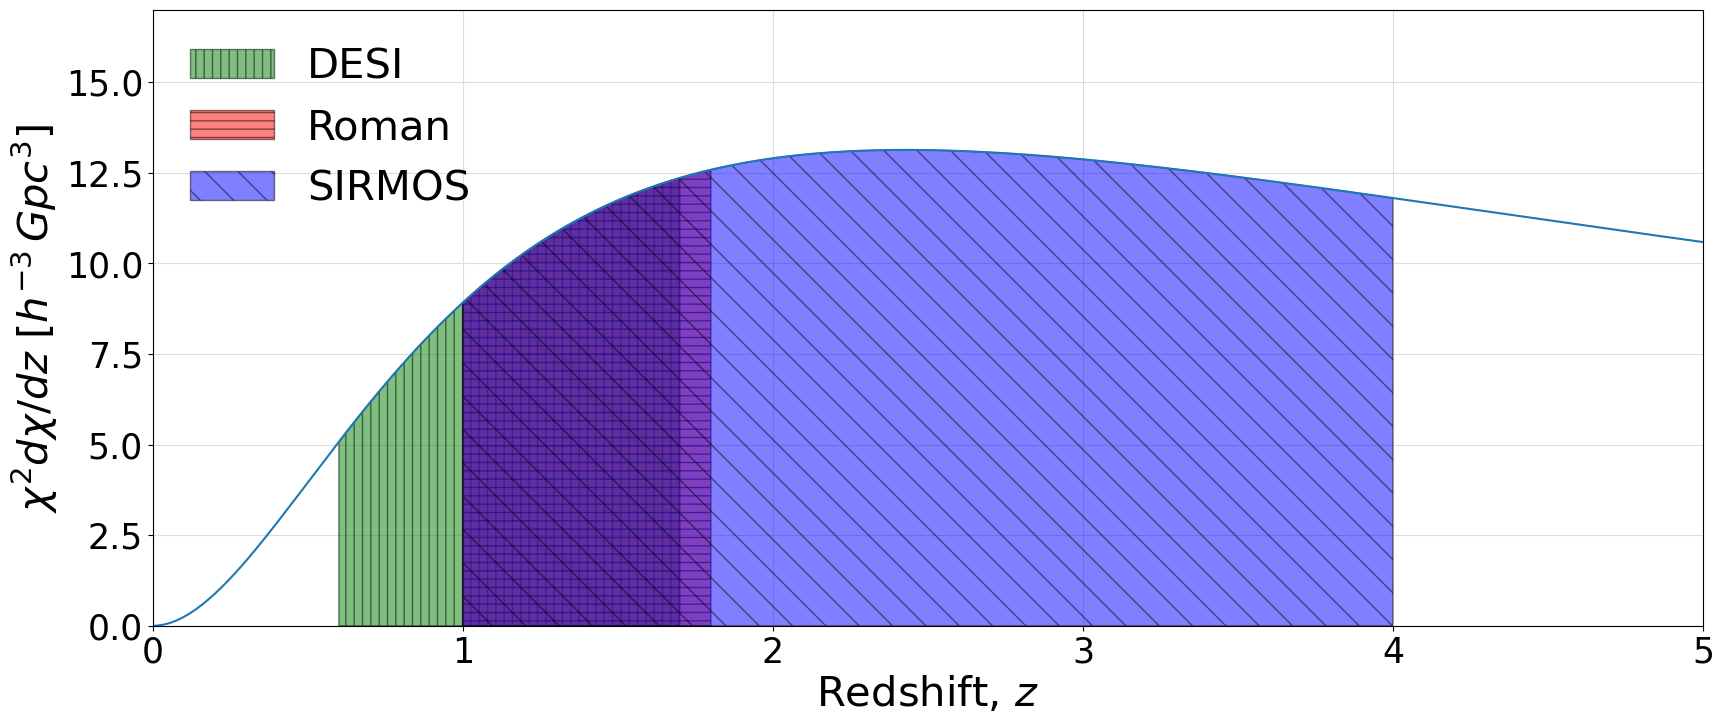

In [210]:
def g(z, omega_m = 0.3):
    return (5/2) * (omega_m * (1+z)**3) * (1)/((omega_m * (1+z)**3)**(4/7) - (1 - (omega_m * (1+z)**3)) + (1 + ((1/2)*(omega_m * (1+z)**3))) + (1 + ((1/70)*(1-(omega_m * (1+z)**3)))))

def D(z):
    return g(z)/((1+z)*g(0))

#define the overall function
def func(z):
    def integrand(z):
        return 1/np.sqrt((matter * (1+z)**3 + darkmatter))
    integral, _ = scipy.integrate.quad(integrand, 0, z)
    return (c/100*10**(-3))**3 * (1/np.sqrt(matter*(1+z)**3 + darkmatter)) * integral**2

c = 3*10**5 #km/s
#H0 = 70*10**3 #km/s/Gpc
matter =  0.31
darkmatter = 0.69 

def co_move_volume(z):
    return func(z) / (4 * np.pi)

#both dimentionless as they're ratios (epsilon_i/epsilon_c or roe_i/roe_c)

#create range of z for function to use
z = np.arange(0,10,0.01)
result = np.vectorize(func)(z)

#plot result
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(z, result)
ax.fill_between(z, result, 0, where = (z >= 0.6) & (z <= 1.7),color = 'green', hatch = '||', edgecolor = 'black', label = 'DESI', alpha = 0.5)
ax.fill_between(z, result, 0, where = (z >= 1) & (z <= 1.8),color = 'red', label = "Roman", hatch = '--', edgecolor = 'black', alpha = 0.5)
ax.fill_between(z, result, 0, where = (z >= 1) & (z <= 4),color = 'blue', label = "SIRMOS", alpha = 0.5, hatch = '\\', edgecolor = 'black')
plt.ylabel('$\chi^2 d\chi/dz$ $[h^{-3} \, Gpc^3]$', fontsize = 30)
plt.xlabel('Redshift, $z$', fontsize = 30)
plt.grid(c='gainsboro')
plt.legend(frameon = False, fontsize = 30)
ax.tick_params(axis='both', labelsize=25) 
plt.rc('axes', axisbelow=True)
plt.xlim(0,5)
plt.ylim(0,17)
plt.savefig("comoving_volme.pdf")
plt.show()